In [1]:
## Setup

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import copy
import matplotlib
import matplotlib.pyplot as plt
import random
import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

dtype = torch.float32

from utils.datasets import noisy_dataset
from utils.models import fcn, fcn_norm
from utils.optimization import train_one_epoch_grokking, train_grokking_batchstep, check_accuracy_grokking, calculate_loss
from utils.data_processing import calculate_ipr

random.seed(0)
pair_seed = 420

############## Use GPU ##############
USE_GPU = False
#####################################
if USE_GPU == True and torch.cuda.is_available():
    device = torch.device('cuda:0')
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
elif USE_GPU and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f'using device: {device}')

using device: cpu


# Grokking Intro figure

In [2]:
## Hyperparameters

p  = 97
data_frac = 0.5
noise_level = 0.0

N = 500
dp = 0.0

epochs = 100
data_every = epochs // 50
t = 10000000000
lr = 1e-2
wd = 5.0

r = 2


## Dataset

dataset_dict = noisy_dataset(p, pair_seed, data_frac, noise_level, device, dtype, operation='addition', fixed_seed=True)

X_train = dataset_dict['X_train']; Y_train = dataset_dict['Y_train']; X_test = dataset_dict['X_test']; Y_test = dataset_dict['Y_test']
X_og = dataset_dict['X_og']; Y_og = dataset_dict['Y_og']; Y_noisy = dataset_dict['Y_noisy']; orderlist = dataset_dict['orderlist']

total_size = Y_og.shape[0]
train_size = int(p**2 * data_frac)
n_noise = int(train_size * noise_level)

In [3]:
## Training

## Model
model = fcn(2*p, N, p, dp=dp)


## Data Arrays
data_epochs = np.arange(data_every, epochs+1, data_every)
if 1 not in data_epochs: 
    data_epochs = np.insert(data_epochs, 0, 1)
if epochs not in data_epochs: 
    data_epochs = np.append(data_epochs, epochs)
    
    
train_losses = np.empty(data_epochs.shape[0], float)
test_losses = np.empty(data_epochs.shape[0], float)
train_accs = np.empty(data_epochs.shape[0], float)
test_accs = np.empty(data_epochs.shape[0], float)

init_weights = {
    'U' : copy.deepcopy(model.fc1.weight.data[:, :p]).detach().cpu().numpy(),
    'V' : copy.deepcopy(model.fc1.weight.data[:, p:]).detach().cpu().numpy(),
    'W' : copy.deepcopy(model.fc2.weight.data[:, :]).detach().cpu().numpy()
    
}

iprs = {
    'U' : np.empty((data_epochs.shape[0], N), float),
    'V' : np.empty((data_epochs.shape[0], N), float),
    'W' : np.empty((data_epochs.shape[0], N), float),
}


## Training loop
optimizer = optim.AdamW(model.parameters(), lr=lr,  weight_decay=wd, betas=(0.9, 0.98), eps=1e-08)


i_d = 0
for epoch in range(1,epochs+1):
    if epoch in data_epochs:
        if_data = True
    else:
        if_data = False
        
    train_data = train_one_epoch_grokking(
        model, optimizer, t, X_train, Y_train, X_test, Y_test,
        dtype, device, losstype='MSE', if_data=if_data, verbose=False
    )
    
    ## collect data
    if if_data:
        train_losses[i_d] = train_data['loss'][-1]
        test_losses[i_d] = train_data['val_loss'][-1]
        train_accs[i_d] = train_data['tr_acc'][-1]
        test_accs[i_d] = train_data['val_acc'][-1]
        
        U = copy.deepcopy(model.fc1.weight.data[:, :p]).detach().cpu().numpy()
        V = copy.deepcopy(model.fc1.weight.data[:, p:]).detach().cpu().numpy()
        W = copy.deepcopy(model.fc2.weight.data).detach().cpu().numpy()

        for k in range(N):
            iprs['U'][i_d, k] = calculate_ipr( np.absolute(np.fft.rfft(U[k])), r )
            iprs['V'][i_d, k]  = calculate_ipr( np.absolute( np.fft.rfft(V[k])), r )
            iprs['W'][i_d, k] = calculate_ipr( np.absolute( np.fft.rfft(W[:,k])), r )

        print(f'epoch epochs:{epoch} \t train_loss:{train_losses[i_d]} \t test_loss:{test_losses[i_d]} \t train_acc:{train_accs[i_d]} \t test_acc:{test_accs[i_d]}')
        
        i_d += 1


final_weights = {
    'U' : copy.deepcopy(model.fc1.weight.data[:, :p]).detach().cpu().numpy(),
    'V' : copy.deepcopy(model.fc1.weight.data[:, p:]).detach().cpu().numpy(),
    'W' : copy.deepcopy(model.fc2.weight.data[:, :]).detach().cpu().numpy()
    
}


## Print training data at the end of training
print('')       
print('final train loss : {:}'.format(train_losses[-1]))
print('final test loss : {:}'.format(test_losses[-1]))
print('final train acc : {:}'.format(train_accs[-1]))
print('final test acc : {:}'.format(test_accs[-1]))

epoch epochs:1 	 train_loss:0.010402151383459568 	 test_loss:0.010415636003017426 	 train_acc:0.050170068027210885 	 test_acc:0.0061636556854410204
epoch epochs:2 	 train_loss:0.010284983552992344 	 test_loss:0.010313521139323711 	 train_acc:0.12670068027210885 	 test_acc:0.0025504782146652497
epoch epochs:4 	 train_loss:0.010064386762678623 	 test_loss:0.010309707373380661 	 train_acc:0.2342687074829932 	 test_acc:0.0021253985122210413
epoch epochs:6 	 train_loss:0.010006438009440899 	 test_loss:0.010311565361917019 	 train_acc:0.37287414965986393 	 test_acc:0.0025504782146652497
epoch epochs:8 	 train_loss:0.009916075505316257 	 test_loss:0.010345186106860638 	 train_acc:0.6464710884353742 	 test_acc:0.0006376195536663124
epoch epochs:10 	 train_loss:0.009835530072450638 	 test_loss:0.010380975902080536 	 train_acc:0.8163265306122449 	 test_acc:0.0
epoch epochs:12 	 train_loss:0.009684284217655659 	 test_loss:0.010441393591463566 	 train_acc:0.8584183673469388 	 test_acc:0.0002125398

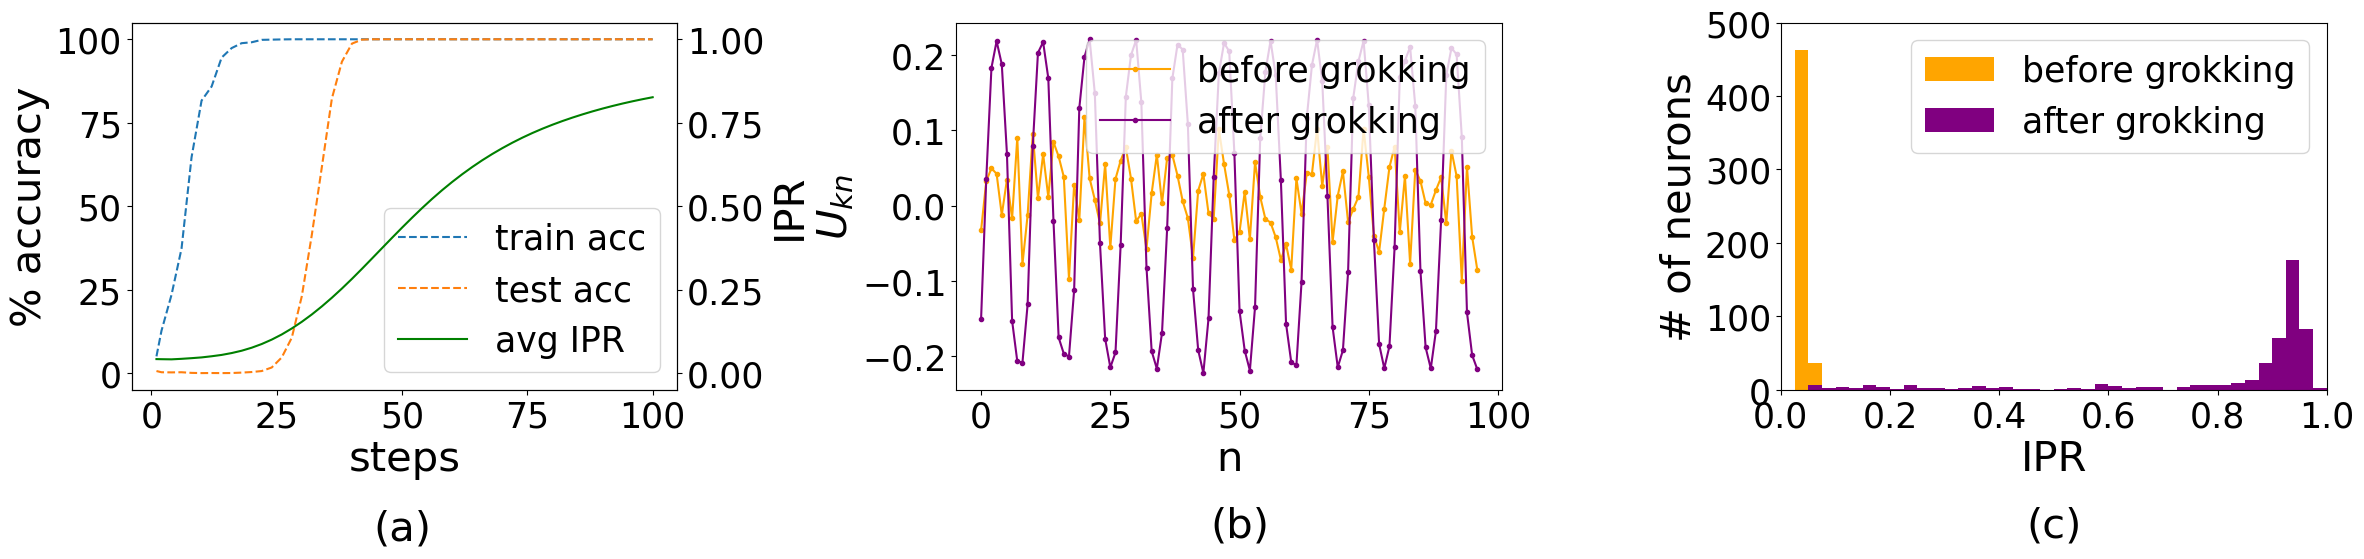

In [4]:
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25
plt.rcParams['legend.title_fontsize'] = 25
plt.rcParams['legend.fontsize'] = 25
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

fig, axs = plt.subplots(1,3, figsize=(24,6.5))

axs[0].set_xlabel('steps')
axs[0].set_ylabel('accuracy (%)')
axs[0].set_ylim(-5, 105)
axs[0].plot(data_epochs, 100*train_accs, label='train acc', linestyle='dashed')
axs[0].plot(data_epochs, 100*test_accs, label='test acc', linestyle='dashed')
lines, labels = axs[0].get_legend_handles_labels()

ax2 = axs[0].twinx()

ax2.set_ylabel('IPR')
ax2.set_ylim(-0.05, 1.05)
ax2.plot(data_epochs, 1/3 * (iprs['U'] + iprs['V'] + iprs['W']).mean(-1), color='green', label='avg IPR' )
line, label = ax2.get_legend_handles_labels()
lines.append(line[0]); labels.append(label[0])

axs[0].legend(lines, labels, loc='lower right', bbox_to_anchor=(1.0, 0.0))
axs[0].text(50, -50, '(a)', horizontalalignment='center', fontsize=30)


k = 70

axs[1].set_xlabel('n')
axs[1].set_ylabel('$U_{kn}$')
axs[1].plot(init_weights['U'][k], '.-', color='orange', label='before grokking')
axs[1].plot(final_weights['U'][k], '.-', color='purple', label='after grokking')
axs[1].legend(loc='upper right')
axs[1].text(50, -0.44, '(b)', horizontalalignment='center', fontsize=30)

        
bins = np.linspace(0,1,41)

axs[2].set_xlabel('IPR')
axs[2].set_ylabel('# of neurons')
axs[2].set_xlim(0,1)
axs[2].set_ylim(0,500)
axs[2].hist(1/3 * (iprs['U'][0] + iprs['V'][0] + iprs['W'][0]), bins=bins, color='orange', label='before grokking')
axs[2].hist(1/3 * (iprs['U'][-1] + iprs['V'][-1] + iprs['W'][-1]), bins=bins, color='purple', label='after grokking')
axs[2].legend()
axs[2].text(0.5, -200, '(c)', horizontalalignment='center', fontsize=30)

plt.tight_layout(pad=2.0)
plt.show()

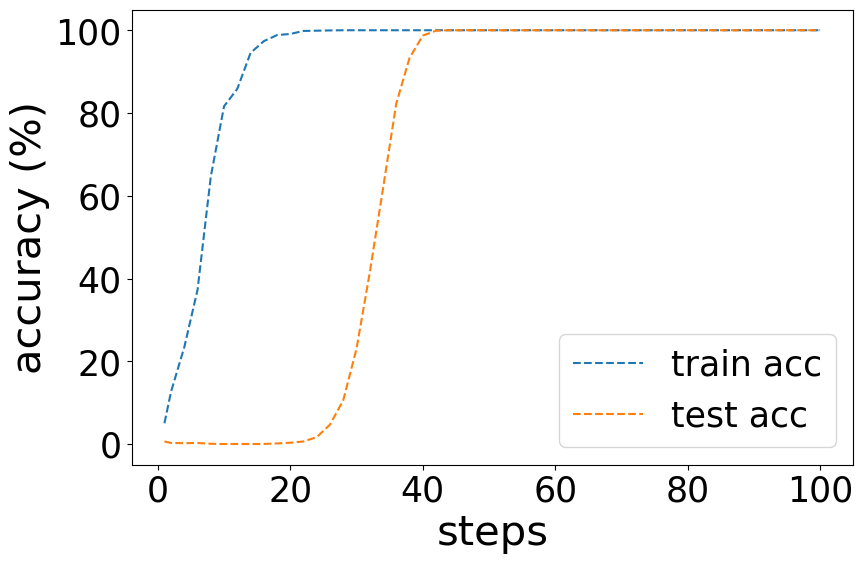

In [15]:
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25
plt.rcParams['legend.title_fontsize'] = 25
plt.rcParams['legend.fontsize'] = 25
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

fig, axs = plt.subplots(1,1, figsize=(9,6))

axs.set_xlabel('steps')
axs.set_ylabel('accuracy (%)')
axs.set_ylim(-5, 105)
axs.plot(data_epochs, 100*train_accs, label='train acc', linestyle='dashed')
axs.plot(data_epochs, 100*test_accs, label='test acc', linestyle='dashed')
axs.legend()

plt.tight_layout(pad=2.0)
plt.savefig('./grokking_curve.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Coexistence

In [5]:
## Hyperparameters

p  = 97
data_frac = 0.5
noise_level = 0.35

N = 500
dp = 0.0

epochs = 1000
data_every = epochs // 50
t = 10000000000
lr = 1e-2
wd = 0.0

r = 2


## Dataset

dataset_dict = noisy_dataset(p, pair_seed, data_frac, noise_level, device, dtype, operation='addition', fixed_seed=True)

X_train = dataset_dict['X_train']; Y_train = dataset_dict['Y_train']; X_test = dataset_dict['X_test']; Y_test = dataset_dict['Y_test']
X_og = dataset_dict['X_og']; Y_og = dataset_dict['Y_og']; Y_noisy = dataset_dict['Y_noisy']; orderlist = dataset_dict['orderlist']

total_size = Y_og.shape[0]
train_size = int(p**2 * data_frac)
n_noise = int(train_size * noise_level)

In [6]:
## Training

## Model
model = fcn(2*p, N, p, dp=dp)


## Data Arrays
data_epochs = np.arange(data_every, epochs+1, data_every)
if 1 not in data_epochs: 
    data_epochs = np.insert(data_epochs, 0, 1)
if epochs not in data_epochs: 
    data_epochs = np.append(data_epochs, epochs)
    
    
train_losses = np.empty(data_epochs.shape[0], float)
test_losses = np.empty(data_epochs.shape[0], float)
train_accs = np.empty(data_epochs.shape[0], float)
test_accs = np.empty(data_epochs.shape[0], float)


weight_norms = {
    'U' : np.empty(data_epochs.shape[0], float),
    'V' : np.empty(data_epochs.shape[0], float),
    'W' : np.empty(data_epochs.shape[0], float)
}


iprs = {
    'U' : np.empty((data_epochs.shape[0], N), float),
    'V' : np.empty((data_epochs.shape[0], N), float),
    'W' : np.empty((data_epochs.shape[0], N), float)
}


## Training loop
optimizer = optim.AdamW(model.parameters(), lr=lr,  weight_decay=wd, betas=(0.9, 0.98), eps=1e-08)


i_d = 0
for epoch in range(1,epochs+1):
    if epoch in data_epochs:
        if_data = True
    else:
        if_data = False
        
    train_data = train_one_epoch_grokking(
        model, optimizer, t, X_train, Y_train, X_test, Y_test,
        dtype, device, losstype='MSE', if_data=if_data, verbose=False
    )
    
    ## collect data
    if if_data:
        train_losses[i_d] = train_data['loss'][-1]
        test_losses[i_d] = train_data['val_loss'][-1]
        train_accs[i_d] = train_data['tr_acc'][-1]
        test_accs[i_d] = train_data['val_acc'][-1]
        
        U = copy.deepcopy(model.fc1.weight.data[:, :p]).detach().cpu().numpy()
        V = copy.deepcopy(model.fc1.weight.data[:, p:]).detach().cpu().numpy()
        W = copy.deepcopy(model.fc2.weight.data).detach().cpu().numpy()

        weight_norms['U'][i_d] = np.sqrt( (np.abs(U)**2).sum() )
        weight_norms['V'][i_d] = np.sqrt( (np.abs(V)**2).sum() )
        weight_norms['W'][i_d] = np.sqrt( (np.abs(W)**2).sum() )

        for k in range(N):
            iprs['U'][i_d, k] = calculate_ipr( np.absolute(np.fft.rfft(U[k])), r )
            iprs['V'][i_d, k]  = calculate_ipr( np.absolute( np.fft.rfft(V[k])), r )
            iprs['W'][i_d, k] = calculate_ipr( np.absolute( np.fft.rfft(W[:,k])), r )

        print(f'epoch epochs:{epoch} \t train_loss:{train_losses[i_d]} \t test_loss:{test_losses[i_d]} \t train_acc:{train_accs[i_d]} \t test_acc:{test_accs[i_d]}')
        
        i_d += 1


## Print training data at the end of training
print('')       
print('final train loss : {:}'.format(train_losses[-1]))
print('final test loss : {:}'.format(test_losses[-1]))
print('final train acc : {:}'.format(train_accs[-1]))
print('final test acc : {:}'.format(test_accs[-1]))

epoch epochs:1 	 train_loss:0.010413740761578083 	 test_loss:0.010478144511580467 	 train_acc:0.051658163265306124 	 test_acc:0.0076514346439957494
epoch epochs:20 	 train_loss:0.007833055220544338 	 test_loss:0.01278685312718153 	 train_acc:0.9955357142857143 	 test_acc:0.003188097768331562
epoch epochs:40 	 train_loss:0.00635603116825223 	 test_loss:0.014826697297394276 	 train_acc:1.0 	 test_acc:0.007226354941551541
epoch epochs:60 	 train_loss:0.005661047995090485 	 test_loss:0.015977291390299797 	 train_acc:1.0 	 test_acc:0.010839532412327312
epoch epochs:80 	 train_loss:0.0052738795056939125 	 test_loss:0.016482416540384293 	 train_acc:1.0 	 test_acc:0.017215727948990435
epoch epochs:100 	 train_loss:0.005007733590900898 	 test_loss:0.016624679788947105 	 train_acc:1.0 	 test_acc:0.02975557917109458
epoch epochs:120 	 train_loss:0.0048029604367911816 	 test_loss:0.016628077253699303 	 train_acc:1.0 	 test_acc:0.04760892667375133
epoch epochs:140 	 train_loss:0.004638071171939373 

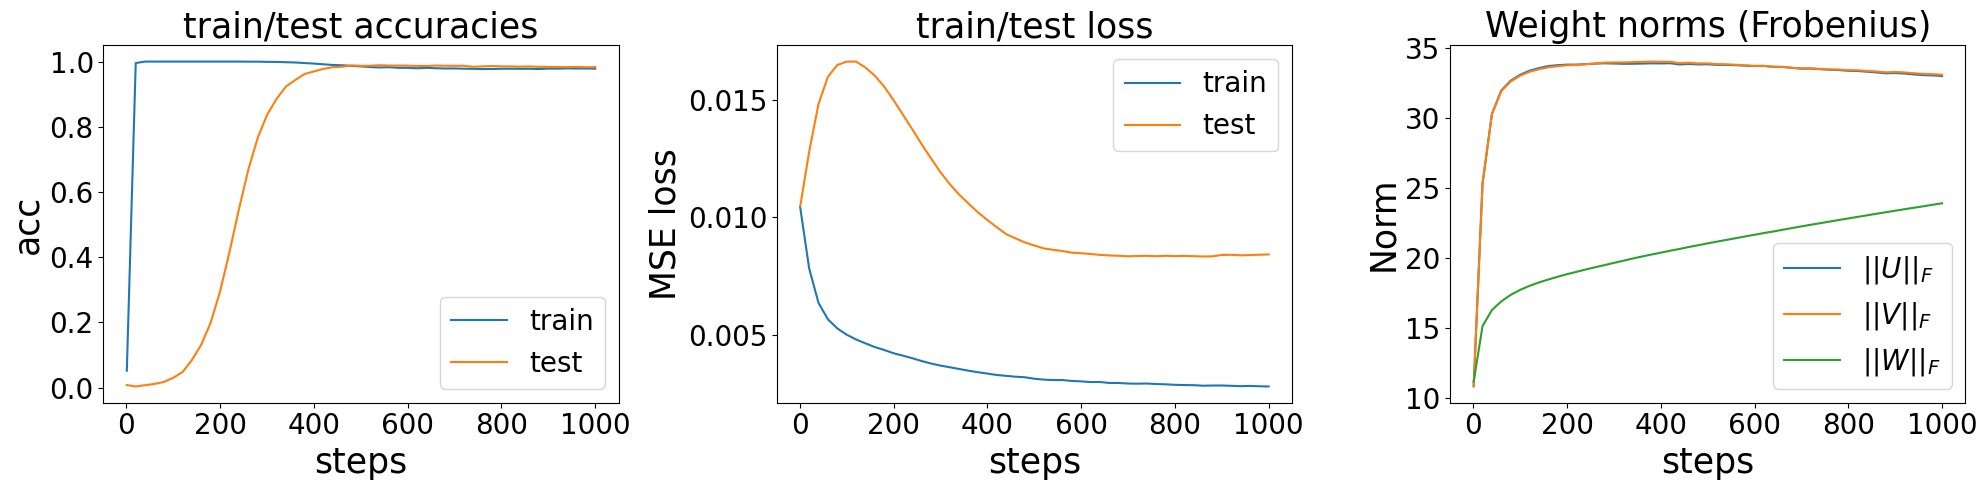

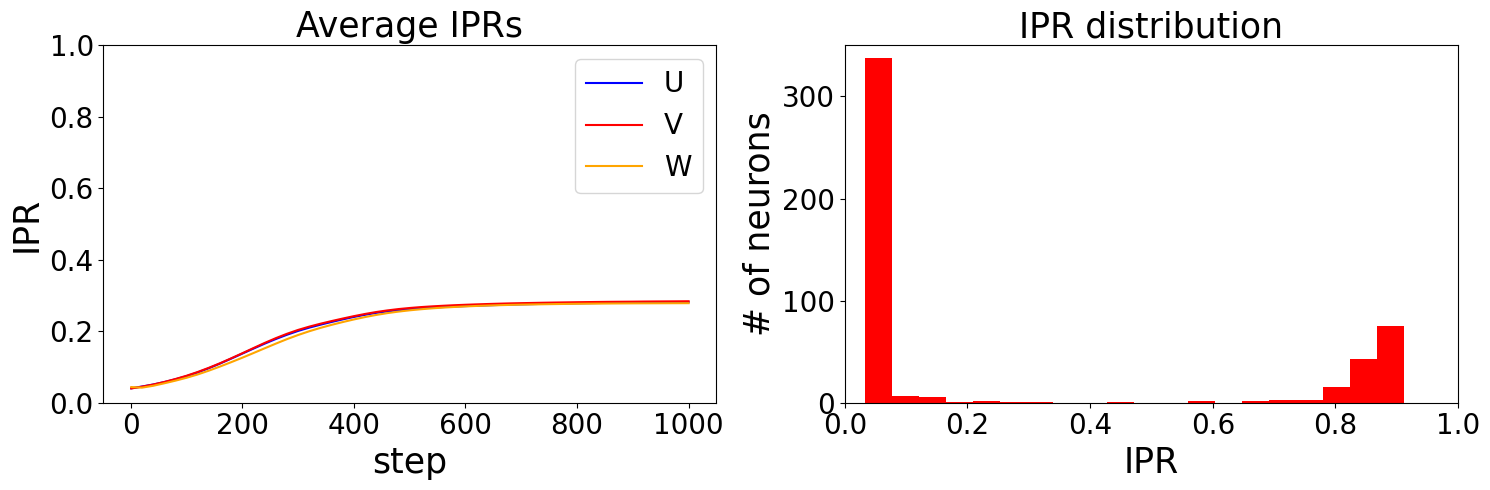

In [7]:
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.title_fontsize'] = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['axes.labelsize'] = 25
plt.rcParams['axes.titlesize'] = 25

## Plot stuff

fig = plt.figure(figsize=(20,5))

## Accuracies
plt.subplot(1,3,1)
plt.title('train/test accuracies')
plt.xlabel('steps')
plt.ylabel('acc')
plt.plot(data_epochs, train_accs, label='train')
plt.plot(data_epochs, test_accs, label='test')
# plt.axhline(y=1.0, color='black', linestyle='dashed')
plt.legend()

## Losses
plt.subplot(1,3,2)
plt.title('train/test loss')
plt.xlabel('steps')
plt.ylabel('MSE loss')
plt.plot(data_epochs, train_losses, label='train')
plt.plot(data_epochs, test_losses, label='test')
plt.legend()

## Weight Norms
plt.subplot(1,3,3)
plt.title('Weight norms (Frobenius)')
plt.xlabel('steps')
plt.ylabel('Norm')
plt.plot(data_epochs, weight_norms['U'], label='$||U||_F$')
plt.plot(data_epochs, weight_norms['V'], label='$||V||_F$')
plt.plot(data_epochs, weight_norms['W'], label='$||W||_F$')
plt.legend()

fig.tight_layout()



fig = plt.figure(figsize=(15,5))
        
plt.subplot(1,2,1)
plt.title('Average IPRs')
plt.xlabel('step')
plt.ylabel('IPR')
plt.ylim(0,1)
plt.plot(data_epochs, iprs['U'].mean(axis=1), color='blue', label='U')
plt.plot(data_epochs, iprs['V'].mean(axis=1), color='red', label='V')
plt.plot(data_epochs, iprs['W'].mean(axis=1), color='orange', label='W')
# plt.axhline(y=1.0, color='black', linestyle='dashed', label='pure freq')
plt.legend()

plt.subplot(1,2,2)
plt.title('IPR distribution')
plt.xlabel('IPR')
plt.ylabel('# of neurons')
plt.xlim(0,1)
plt.ylim(0,350)
plt.hist(1/3 * (iprs['U'][-1] + iprs['V'][-1] + iprs['W'][-1]), bins=20, color='red')

fig.tight_layout()

plt.show()

# Partial Inversion

In [8]:
## Hyperparameters

p  = 97
data_frac = 0.5
noise_level = 0.35

N = 500
dp = 0.0

epochs = 500
data_every = epochs // 50
t = 10000000000
lr = 1e-2
wd = 5.0

r = 2


## Dataset

dataset_dict = noisy_dataset(p, pair_seed, data_frac, noise_level, device, dtype, operation='addition', fixed_seed=True)

X_train = dataset_dict['X_train']; Y_train = dataset_dict['Y_train']; X_test = dataset_dict['X_test']; Y_test = dataset_dict['Y_test']
X_og = dataset_dict['X_og']; Y_og = dataset_dict['Y_og']; Y_noisy = dataset_dict['Y_noisy']; orderlist = dataset_dict['orderlist']

total_size = Y_og.shape[0]
train_size = int(p**2 * data_frac)
n_noise = int(train_size * noise_level)

In [9]:
## Training

## Model
model = fcn(2*p, N, p, dp=dp)


## Data Arrays
data_epochs = np.arange(data_every, epochs+1, data_every)
if 1 not in data_epochs: 
    data_epochs = np.insert(data_epochs, 0, 1)
if epochs not in data_epochs: 
    data_epochs = np.append(data_epochs, epochs)
    
    
train_losses = np.empty(data_epochs.shape[0], float)
test_losses = np.empty(data_epochs.shape[0], float)
train_accs = np.empty(data_epochs.shape[0], float)
test_accs = np.empty(data_epochs.shape[0], float)


weight_norms = {
    'U' : np.empty(data_epochs.shape[0], float),
    'V' : np.empty(data_epochs.shape[0], float),
    'W' : np.empty(data_epochs.shape[0], float)
}


iprs = {
    'U' : np.empty((data_epochs.shape[0], N), float),
    'V' : np.empty((data_epochs.shape[0], N), float),
    'W' : np.empty((data_epochs.shape[0], N), float)
}


## Training loop
optimizer = optim.AdamW(model.parameters(), lr=lr,  weight_decay=wd, betas=(0.9, 0.98), eps=1e-08)


i_d = 0
for epoch in range(1,epochs+1):
    if epoch in data_epochs:
        if_data = True
    else:
        if_data = False
        
    train_data = train_one_epoch_grokking(
        model, optimizer, t, X_train, Y_train, X_test, Y_test,
        dtype, device, losstype='MSE', if_data=if_data, verbose=False
    )
    
    ## collect data
    if if_data:
        train_losses[i_d] = train_data['loss'][-1]
        test_losses[i_d] = train_data['val_loss'][-1]
        train_accs[i_d] = train_data['tr_acc'][-1]
        test_accs[i_d] = train_data['val_acc'][-1]
        
        U = copy.deepcopy(model.fc1.weight.data[:, :p]).detach().cpu().numpy()
        V = copy.deepcopy(model.fc1.weight.data[:, p:]).detach().cpu().numpy()
        W = copy.deepcopy(model.fc2.weight.data).detach().cpu().numpy()

        weight_norms['U'][i_d] = np.sqrt( (np.abs(U)**2).sum() )
        weight_norms['V'][i_d] = np.sqrt( (np.abs(V)**2).sum() )
        weight_norms['W'][i_d] = np.sqrt( (np.abs(W)**2).sum() )

        for k in range(N):
            iprs['U'][i_d, k] = calculate_ipr( np.absolute(np.fft.rfft(U[k])), r )
            iprs['V'][i_d, k]  = calculate_ipr( np.absolute( np.fft.rfft(V[k])), r )
            iprs['W'][i_d, k] = calculate_ipr( np.absolute( np.fft.rfft(W[:,k])), r )

        print(f'epoch epochs:{epoch} \t train_loss:{train_losses[i_d]} \t test_loss:{test_losses[i_d]} \t train_acc:{train_accs[i_d]} \t test_acc:{test_accs[i_d]}')
        
        i_d += 1


## Print training data at the end of training
print('')       
print('final train loss : {:}'.format(train_losses[-1]))
print('final test loss : {:}'.format(test_losses[-1]))
print('final train acc : {:}'.format(train_accs[-1]))
print('final test acc : {:}'.format(test_accs[-1]))

epoch epochs:1 	 train_loss:0.010413740761578083 	 test_loss:0.010405117645859718 	 train_acc:0.05399659863945578 	 test_acc:0.0076514346439957494
epoch epochs:10 	 train_loss:0.009783449582755566 	 test_loss:0.010362975299358368 	 train_acc:0.7285289115646258 	 test_acc:0.0012752391073326248
epoch epochs:20 	 train_loss:0.00867085438221693 	 test_loss:0.01093242783099413 	 train_acc:0.9678996598639455 	 test_acc:0.0023379383634431457
epoch epochs:30 	 train_loss:0.007633268367499113 	 test_loss:0.01144612766802311 	 train_acc:0.9985119047619048 	 test_acc:0.004250797024442083
epoch epochs:40 	 train_loss:0.007129085715860128 	 test_loss:0.011504219844937325 	 train_acc:0.9997874149659864 	 test_acc:0.007863974495217854
epoch epochs:50 	 train_loss:0.00679880240932107 	 test_loss:0.011514918878674507 	 train_acc:1.0 	 test_acc:0.013602550478214665
epoch epochs:60 	 train_loss:0.00656496686860919 	 test_loss:0.011354738846421242 	 train_acc:1.0 	 test_acc:0.030605738575982998
epoch epoc

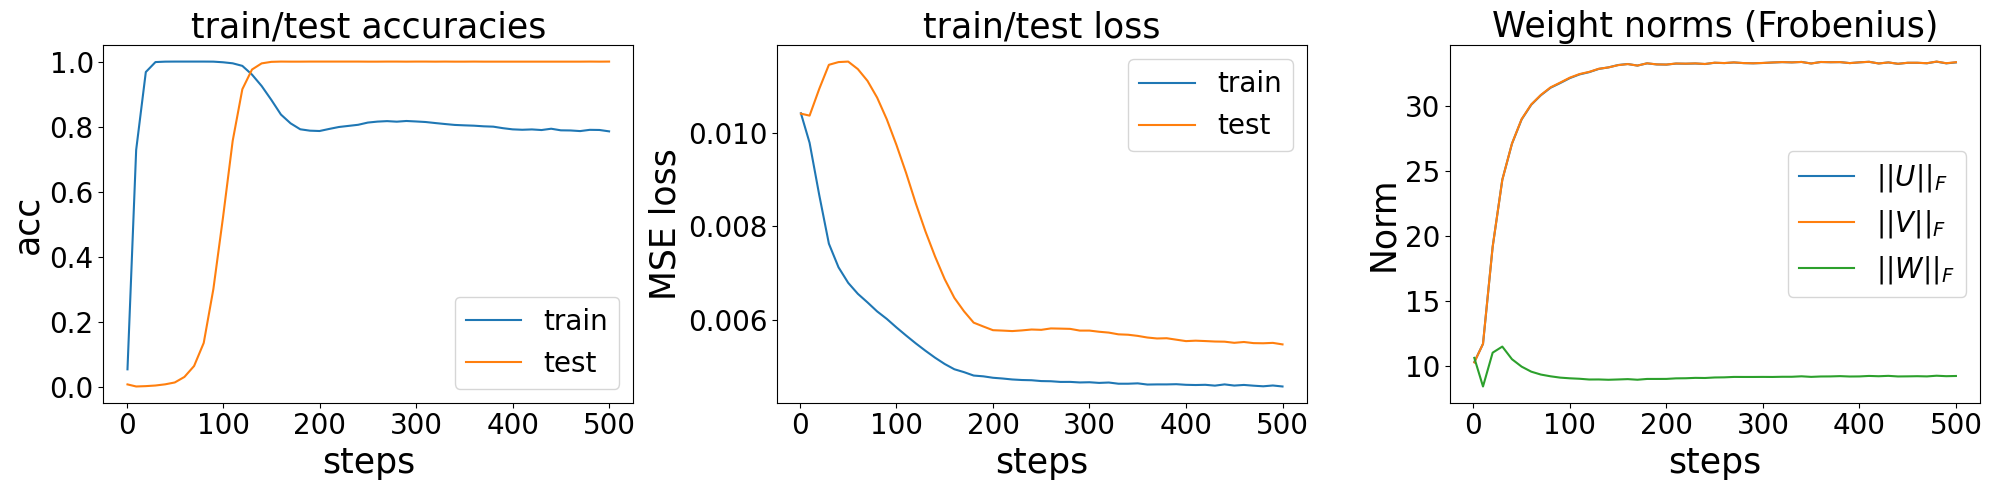

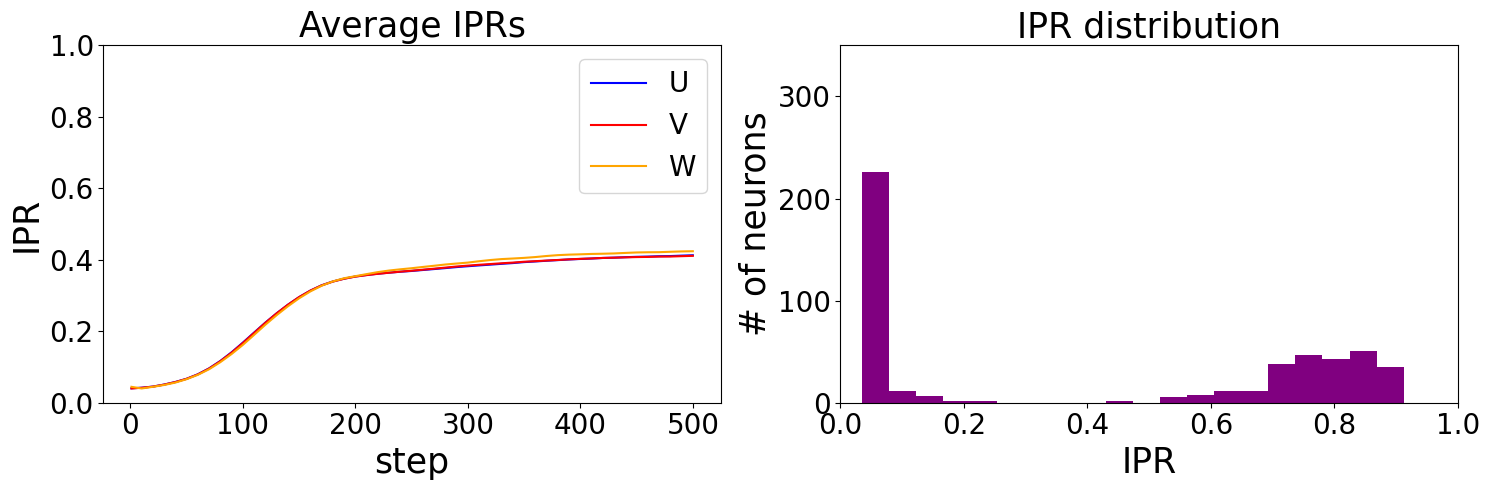

In [10]:
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.title_fontsize'] = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['axes.labelsize'] = 25
plt.rcParams['axes.titlesize'] = 25

## Plot stuff

fig = plt.figure(figsize=(20,5))

## Accuracies
plt.subplot(1,3,1)
plt.title('train/test accuracies')
plt.xlabel('steps')
plt.ylabel('acc')
plt.plot(data_epochs, train_accs, label='train')
plt.plot(data_epochs, test_accs, label='test')
# plt.axhline(y=1.0, color='black', linestyle='dashed')
plt.legend()

## Losses
plt.subplot(1,3,2)
plt.title('train/test loss')
plt.xlabel('steps')
plt.ylabel('MSE loss')
plt.plot(data_epochs, train_losses, label='train')
plt.plot(data_epochs, test_losses, label='test')
plt.legend()

## Weight Norms
plt.subplot(1,3,3)
plt.title('Weight norms (Frobenius)')
plt.xlabel('steps')
plt.ylabel('Norm')
plt.plot(data_epochs, weight_norms['U'], label='$||U||_F$')
plt.plot(data_epochs, weight_norms['V'], label='$||V||_F$')
plt.plot(data_epochs, weight_norms['W'], label='$||W||_F$')
plt.legend()

fig.tight_layout()


fig = plt.figure(figsize=(15,5))
        
plt.subplot(1,2,1)
plt.title('Average IPRs')
plt.xlabel('step')
plt.ylabel('IPR')
plt.ylim(0,1)
plt.plot(data_epochs, iprs['U'].mean(axis=1), color='blue', label='U')
plt.plot(data_epochs, iprs['V'].mean(axis=1), color='red', label='V')
plt.plot(data_epochs, iprs['W'].mean(axis=1), color='orange', label='W')
# plt.axhline(y=1.0, color='black', linestyle='dashed', label='pure freq')
plt.legend()

plt.subplot(1,2,2)
plt.title('IPR distribution')
plt.xlabel('IPR')
plt.ylabel('# of neurons')
plt.xlim(0,1)
plt.ylim(0,350)
plt.hist(1/3 * (iprs['U'][-1] + iprs['V'][-1] + iprs['W'][-1]), bins=20, color='purple')

fig.tight_layout()

plt.show()

# Full Inversion

In [11]:
## Hyperparameters

p  = 97
data_frac = 0.5
noise_level = 0.35

N = 500
dp = 0.0

epochs = 500
data_every = epochs // 50
t = 10000000000
lr = 1e-2
wd = 15.0

r = 2


## Dataset

dataset_dict = noisy_dataset(p, pair_seed, data_frac, noise_level, device, dtype, operation='addition', fixed_seed=True)

X_train = dataset_dict['X_train']; Y_train = dataset_dict['Y_train']; X_test = dataset_dict['X_test']; Y_test = dataset_dict['Y_test']
X_og = dataset_dict['X_og']; Y_og = dataset_dict['Y_og']; Y_noisy = dataset_dict['Y_noisy']; orderlist = dataset_dict['orderlist']

total_size = Y_og.shape[0]
train_size = int(p**2 * data_frac)
n_noise = int(train_size * noise_level)

In [12]:
## Training

## Model
model = fcn(2*p, N, p, dp=dp)


## Data Arrays
data_epochs = np.arange(data_every, epochs+1, data_every)
if 1 not in data_epochs: 
    data_epochs = np.insert(data_epochs, 0, 1)
if epochs not in data_epochs: 
    data_epochs = np.append(data_epochs, epochs)
    
    
train_losses = np.empty(data_epochs.shape[0], float)
test_losses = np.empty(data_epochs.shape[0], float)
train_accs = np.empty(data_epochs.shape[0], float)
test_accs = np.empty(data_epochs.shape[0], float)


weight_norms = {
    'U' : np.empty(data_epochs.shape[0], float),
    'V' : np.empty(data_epochs.shape[0], float),
    'W' : np.empty(data_epochs.shape[0], float)
}


iprs = {
    'U' : np.empty((data_epochs.shape[0], N), float),
    'V' : np.empty((data_epochs.shape[0], N), float),
    'W' : np.empty((data_epochs.shape[0], N), float)
}


## Training loop
optimizer = optim.AdamW(model.parameters(), lr=lr,  weight_decay=wd, betas=(0.9, 0.98), eps=1e-08)


i_d = 0
for epoch in range(1,epochs+1):
    if epoch in data_epochs:
        if_data = True
    else:
        if_data = False
        
    train_data = train_one_epoch_grokking(
        model, optimizer, t, X_train, Y_train, X_test, Y_test,
        dtype, device, losstype='MSE', if_data=if_data, verbose=False
    )
    
    ## collect data
    if if_data:
        train_losses[i_d] = train_data['loss'][-1]
        test_losses[i_d] = train_data['val_loss'][-1]
        train_accs[i_d] = train_data['tr_acc'][-1]
        test_accs[i_d] = train_data['val_acc'][-1]
        
        U = copy.deepcopy(model.fc1.weight.data[:, :p]).detach().cpu().numpy()
        V = copy.deepcopy(model.fc1.weight.data[:, p:]).detach().cpu().numpy()
        W = copy.deepcopy(model.fc2.weight.data).detach().cpu().numpy()

        weight_norms['U'][i_d] = np.sqrt( (np.abs(U)**2).sum() )
        weight_norms['V'][i_d] = np.sqrt( (np.abs(V)**2).sum() )
        weight_norms['W'][i_d] = np.sqrt( (np.abs(W)**2).sum() )

        for k in range(N):
            iprs['U'][i_d, k] = calculate_ipr( np.absolute(np.fft.rfft(U[k])), r )
            iprs['V'][i_d, k]  = calculate_ipr( np.absolute( np.fft.rfft(V[k])), r )
            iprs['W'][i_d, k] = calculate_ipr( np.absolute( np.fft.rfft(W[:,k])), r )

        print(f'epoch epochs:{epoch} \t train_loss:{train_losses[i_d]} \t test_loss:{test_losses[i_d]} \t train_acc:{train_accs[i_d]} \t test_acc:{test_accs[i_d]}')
        
        i_d += 1


## Print training data at the end of training
print('')       
print('final train loss : {:}'.format(train_losses[-1]))
print('final test loss : {:}'.format(test_losses[-1]))
print('final train acc : {:}'.format(train_accs[-1]))
print('final test acc : {:}'.format(test_accs[-1]))

epoch epochs:1 	 train_loss:0.010413740761578083 	 test_loss:0.010304664261639118 	 train_acc:0.06398809523809523 	 test_acc:0.007438894792773645
epoch epochs:10 	 train_loss:0.010113192722201347 	 test_loss:0.01022292673587799 	 train_acc:0.24000850340136054 	 test_acc:0.003188097768331562
epoch epochs:20 	 train_loss:0.010017937049269676 	 test_loss:0.01023330632597208 	 train_acc:0.6473214285714286 	 test_acc:0.0019128586609989374
epoch epochs:30 	 train_loss:0.009759507142007351 	 test_loss:0.010260893031954765 	 train_acc:0.8696853741496599 	 test_acc:0.0021253985122210413
epoch epochs:40 	 train_loss:0.009324396029114723 	 test_loss:0.010295698419213295 	 train_acc:0.9713010204081632 	 test_acc:0.004888416578108395
epoch epochs:50 	 train_loss:0.008856594562530518 	 test_loss:0.01030974555760622 	 train_acc:0.9963860544217688 	 test_acc:0.011264612114771519
epoch epochs:60 	 train_loss:0.00852319598197937 	 test_loss:0.01026228629052639 	 train_acc:0.9993622448979592 	 test_acc:0

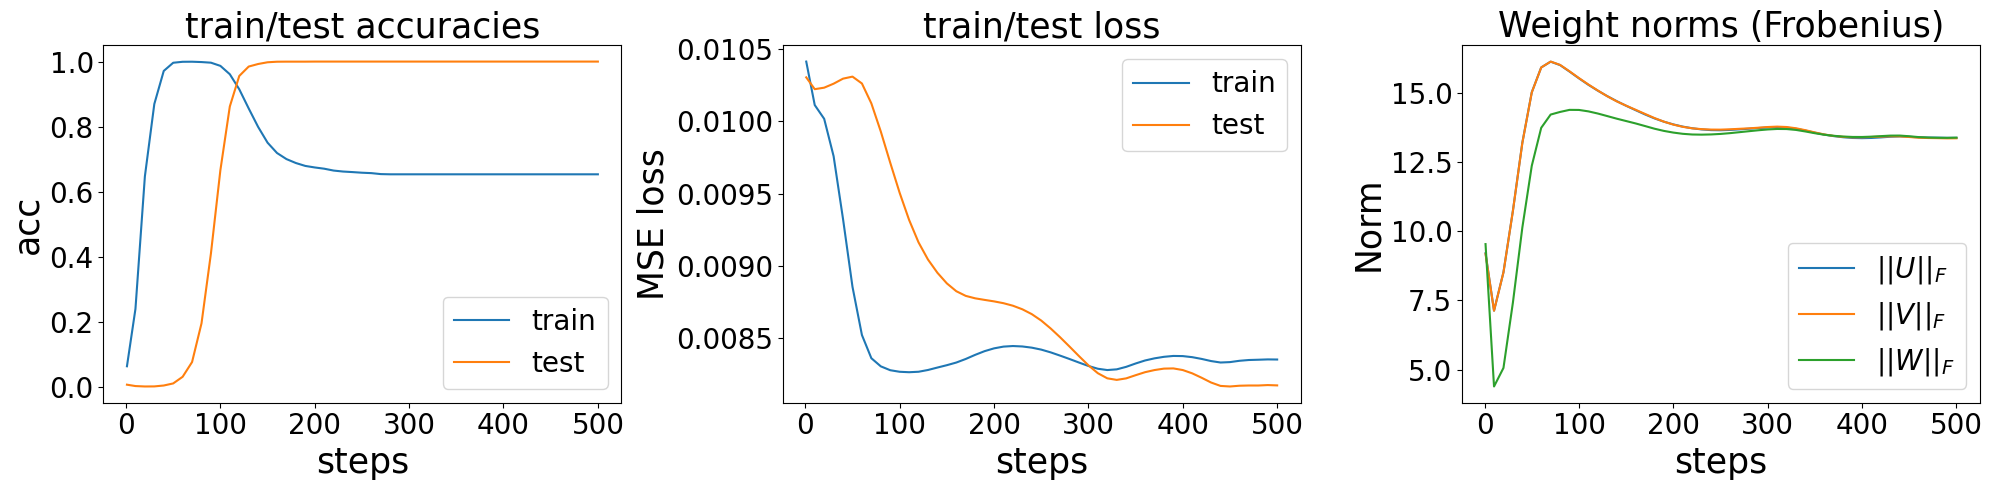

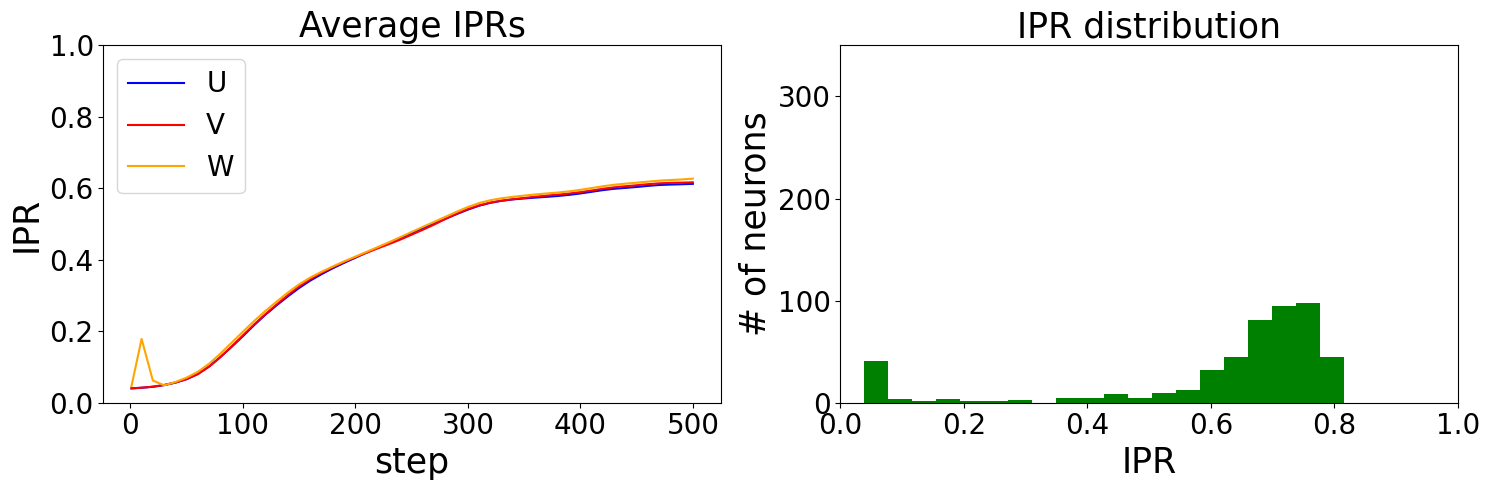

In [13]:
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.title_fontsize'] = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['axes.labelsize'] = 25
plt.rcParams['axes.titlesize'] = 25

## Plot stuff

fig = plt.figure(figsize=(20,5))

## Accuracies
plt.subplot(1,3,1)
plt.title('train/test accuracies')
plt.xlabel('steps')
plt.ylabel('acc')
plt.plot(data_epochs, train_accs, label='train')
plt.plot(data_epochs, test_accs, label='test')
# plt.axhline(y=1.0, color='black', linestyle='dashed')
plt.legend()

## Losses
plt.subplot(1,3,2)
plt.title('train/test loss')
plt.xlabel('steps')
plt.ylabel('MSE loss')
plt.plot(data_epochs, train_losses, label='train')
plt.plot(data_epochs, test_losses, label='test')
plt.legend()

## Weight Norms
plt.subplot(1,3,3)
plt.title('Weight norms (Frobenius)')
plt.xlabel('steps')
plt.ylabel('Norm')
plt.plot(data_epochs, weight_norms['U'], label='$||U||_F$')
plt.plot(data_epochs, weight_norms['V'], label='$||V||_F$')
plt.plot(data_epochs, weight_norms['W'], label='$||W||_F$')
plt.legend()

fig.tight_layout()


fig = plt.figure(figsize=(15,5))
        
plt.subplot(1,2,1)
plt.title('Average IPRs')
plt.xlabel('step')
plt.ylabel('IPR')
plt.ylim(0,1)
plt.plot(data_epochs, iprs['U'].mean(axis=1), color='blue', label='U')
plt.plot(data_epochs, iprs['V'].mean(axis=1), color='red', label='V')
plt.plot(data_epochs, iprs['W'].mean(axis=1), color='orange', label='W')
# plt.axhline(y=1.0, color='black', linestyle='dashed', label='pure freq')
plt.legend()

plt.subplot(1,2,2)
plt.title('IPR distribution')
plt.xlabel('IPR')
plt.ylabel('# of neurons')
plt.xlim(0,1)
plt.ylim(0,350)
plt.hist(1/3 * (iprs['U'][-1] + iprs['V'][-1] + iprs['W'][-1]), bins=20, color='green')

fig.tight_layout()

plt.show()

# Forgetting

In [14]:
## Hyperparameters

p  = 97
data_frac = 0.5
noise_level = 0.35

N = 500
dp = 0.0

epochs = 5000
data_every = epochs // 50
t = 10000000000
lr = 1e-2
wd = 20.0

r = 2


## Dataset

dataset_dict = noisy_dataset(p, pair_seed, data_frac, noise_level, device, dtype, operation='addition', fixed_seed=True)

X_train = dataset_dict['X_train']; Y_train = dataset_dict['Y_train']; X_test = dataset_dict['X_test']; Y_test = dataset_dict['Y_test']
X_og = dataset_dict['X_og']; Y_og = dataset_dict['Y_og']; Y_noisy = dataset_dict['Y_noisy']; orderlist = dataset_dict['orderlist']

total_size = Y_og.shape[0]
train_size = int(p**2 * data_frac)
n_noise = int(train_size * noise_level)

In [15]:
## Training

## Model
model = fcn(2*p, N, p, dp=dp)


## Data Arrays
data_epochs = np.arange(data_every, epochs+1, data_every)
if 1 not in data_epochs: 
    data_epochs = np.insert(data_epochs, 0, 1)
if epochs not in data_epochs: 
    data_epochs = np.append(data_epochs, epochs)
    
    
train_losses = np.empty(data_epochs.shape[0], float)
test_losses = np.empty(data_epochs.shape[0], float)
train_accs = np.empty(data_epochs.shape[0], float)
test_accs = np.empty(data_epochs.shape[0], float)


weight_norms = {
    'U' : np.empty(data_epochs.shape[0], float),
    'V' : np.empty(data_epochs.shape[0], float),
    'W' : np.empty(data_epochs.shape[0], float)
}


iprs = {
    'U' : np.empty((data_epochs.shape[0], N), float),
    'V' : np.empty((data_epochs.shape[0], N), float),
    'W' : np.empty((data_epochs.shape[0], N), float)
}


## Training loop
optimizer = optim.AdamW(model.parameters(), lr=lr,  weight_decay=wd, betas=(0.9, 0.98), eps=1e-08)


i_d = 0
for epoch in range(1,epochs+1):
    if epoch in data_epochs:
        if_data = True
    else:
        if_data = False
        
    train_data = train_one_epoch_grokking(
        model, optimizer, t, X_train, Y_train, X_test, Y_test,
        dtype, device, losstype='MSE', if_data=if_data, verbose=False
    )
    
    ## collect data
    if if_data:
        train_losses[i_d] = train_data['loss'][-1]
        test_losses[i_d] = train_data['val_loss'][-1]
        train_accs[i_d] = train_data['tr_acc'][-1]
        test_accs[i_d] = train_data['val_acc'][-1]
        
        U = copy.deepcopy(model.fc1.weight.data[:, :p]).detach().cpu().numpy()
        V = copy.deepcopy(model.fc1.weight.data[:, p:]).detach().cpu().numpy()
        W = copy.deepcopy(model.fc2.weight.data).detach().cpu().numpy()

        weight_norms['U'][i_d] = np.sqrt( (np.abs(U)**2).sum() )
        weight_norms['V'][i_d] = np.sqrt( (np.abs(V)**2).sum() )
        weight_norms['W'][i_d] = np.sqrt( (np.abs(W)**2).sum() )

        for k in range(N):
            iprs['U'][i_d, k] = calculate_ipr( np.absolute(np.fft.rfft(U[k])), r )
            iprs['V'][i_d, k]  = calculate_ipr( np.absolute( np.fft.rfft(V[k])), r )
            iprs['W'][i_d, k] = calculate_ipr( np.absolute( np.fft.rfft(W[:,k])), r )

        print(f'epoch epochs:{epoch} \t train_loss:{train_losses[i_d]} \t test_loss:{test_losses[i_d]} \t train_acc:{train_accs[i_d]} \t test_acc:{test_accs[i_d]}')
        
        i_d += 1


## Print training data at the end of training
print('')       
print('final train loss : {:}'.format(train_losses[-1]))
print('final test loss : {:}'.format(test_losses[-1]))
print('final train acc : {:}'.format(train_accs[-1]))
print('final test acc : {:}'.format(test_accs[-1]))

epoch epochs:1 	 train_loss:0.010413740761578083 	 test_loss:0.010272963903844357 	 train_acc:0.06866496598639456 	 test_acc:0.007013815090329437
epoch epochs:100 	 train_loss:0.00926404632627964 	 test_loss:0.009895820170640945 	 train_acc:0.9929846938775511 	 test_acc:0.46439957492029754
epoch epochs:200 	 train_loss:0.009497101418673992 	 test_loss:0.009633813984692097 	 train_acc:0.6796343537414966 	 test_acc:0.9985122210414453
epoch epochs:300 	 train_loss:0.009466271847486496 	 test_loss:0.009518015198409557 	 train_acc:0.65625 	 test_acc:1.0
epoch epochs:400 	 train_loss:0.009582094848155975 	 test_loss:0.00958508811891079 	 train_acc:0.6547619047619048 	 test_acc:0.9995749202975558
epoch epochs:500 	 train_loss:0.009683718904852867 	 test_loss:0.009690954349935055 	 train_acc:0.6560374149659864 	 test_acc:0.9995749202975558
epoch epochs:600 	 train_loss:0.009802855551242828 	 test_loss:0.009819461964070797 	 train_acc:0.6619897959183674 	 test_acc:0.9908607863974496
epoch epoch

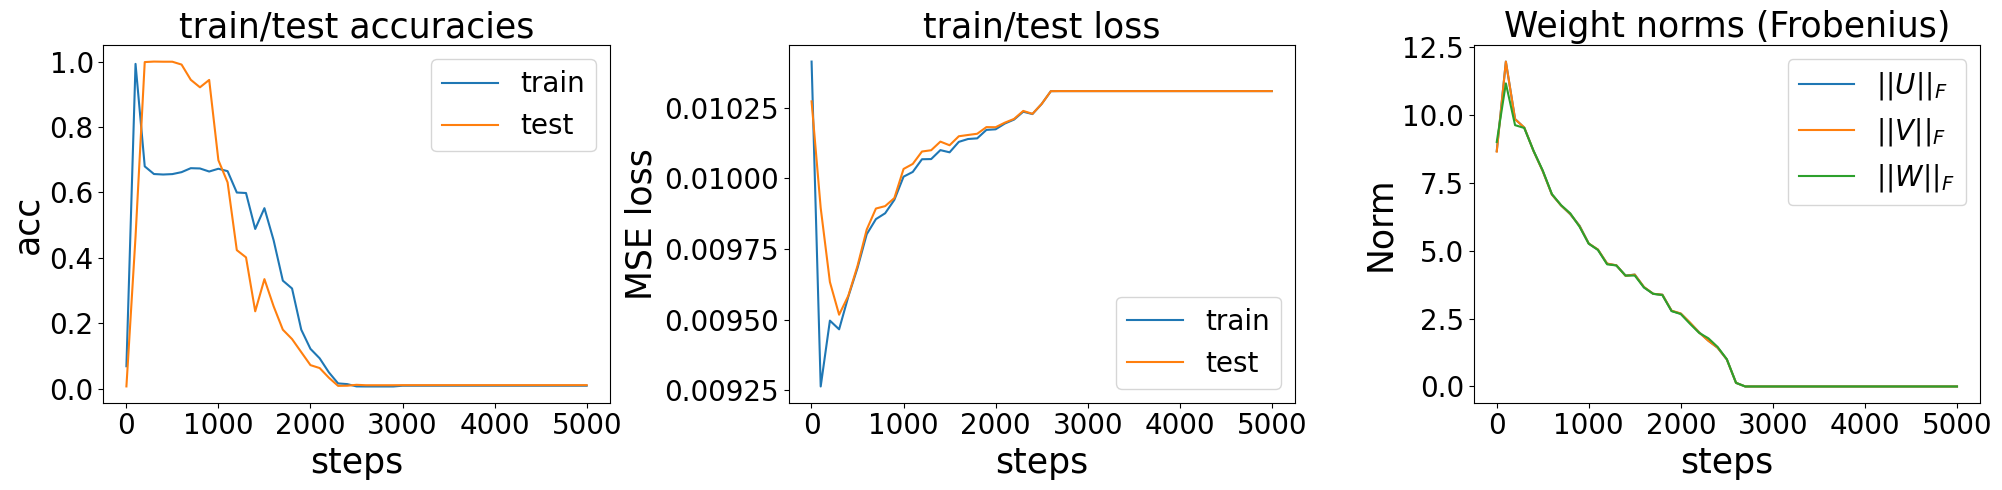

In [16]:
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.title_fontsize'] = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['axes.labelsize'] = 25
plt.rcParams['axes.titlesize'] = 25

## Plot stuff

fig = plt.figure(figsize=(20,5))

## Accuracies
plt.subplot(1,3,1)
plt.title('train/test accuracies')
plt.xlabel('steps')
plt.ylabel('acc')
plt.plot(data_epochs, train_accs, label='train')
plt.plot(data_epochs, test_accs, label='test')
# plt.axhline(y=1.0, color='black', linestyle='dashed')
plt.legend()

## Losses
plt.subplot(1,3,2)
plt.title('train/test loss')
plt.xlabel('steps')
plt.ylabel('MSE loss')
plt.plot(data_epochs, train_losses, label='train')
plt.plot(data_epochs, test_losses, label='test')
plt.legend()

## Weight Norms
plt.subplot(1,3,3)
plt.title('Weight norms (Frobenius)')
plt.xlabel('steps')
plt.ylabel('Norm')
plt.plot(data_epochs, weight_norms['U'], label='$||U||_F$')
plt.plot(data_epochs, weight_norms['V'], label='$||V||_F$')
plt.plot(data_epochs, weight_norms['W'], label='$||W||_F$')
plt.legend()

fig.tight_layout()

plt.show()

# BatchNorm (Full Inversion)

In [17]:
## Hyperparameters

p  = 97
data_frac = 0.65
noise_level = 0.2

N = 500
dp = 0.0

steps = 2000
data_every = steps // 50
t = 10000000000
wd = 0.0
bs = 64
if bs >= 256: lr = 1e-2
else: lr = 1e-2 * np.sqrt(bs/256)

r = 2


## Dataset

dataset_dict = noisy_dataset(p, pair_seed, data_frac, noise_level, device, dtype, operation='addition', fixed_seed=True)

X_train = dataset_dict['X_train']; Y_train = dataset_dict['Y_train']; X_test = dataset_dict['X_test']; Y_test = dataset_dict['Y_test']
X_og = dataset_dict['X_og']; Y_og = dataset_dict['Y_og']; Y_noisy = dataset_dict['Y_noisy']; orderlist = dataset_dict['orderlist']

total_size = Y_og.shape[0]
train_size = int(p**2 * data_frac)
n_noise = int(train_size * noise_level)

In [18]:
## Training

## Model
model = fcn_norm(2*p, N, p, norm='bn')


## Data Arrays
data_steps = np.arange(data_every, steps+1, data_every)
if 1 not in data_steps: 
    data_steps = np.insert(data_steps, 0, 1)
if steps not in data_steps: 
    data_steps = np.append(data_steps, steps)
    
    
train_losses = np.empty(data_steps.shape[0], float)
test_losses = np.empty(data_steps.shape[0], float)
train_accs = np.empty(data_steps.shape[0], float)
test_accs = np.empty(data_steps.shape[0], float)

# norm1_means = np.empty(data_steps.shape[0], float)
# norm1_vars = np.empty(data_steps.shape[0], float)
norm_weights = np.empty((data_steps.shape[0], N), float)

weight_norms = {
    'U' : np.empty(data_steps.shape[0], float),
    'V' : np.empty(data_steps.shape[0], float),
    'W' : np.empty(data_steps.shape[0], float),
    'norm1': np.empty((data_steps.shape[0]), float)
}

iprs = {
    'U' : np.empty((data_steps.shape[0], N), float),
    'V' : np.empty((data_steps.shape[0], N), float),
    'W' : np.empty((data_steps.shape[0], N), float),
}


## Training loop
optimizer = optim.AdamW(model.parameters(), lr=lr,  weight_decay=wd, betas=(0.9, 0.98), eps=1e-08)


i_d = 0
steps_per_epoch = len(X_train) // bs
step = 1
while step <= steps + 1:
    if (step - 1) % steps_per_epoch == 0:
        perms = torch.randperm(len(X_train), device=device)
        perms = perms[:steps_per_epoch * bs]
        perms = perms.view((steps_per_epoch, bs))

    # train_data = train_one_epoch_grokking_batch(
    #     model, optimizer, bs, X_train, Y_train, X_test, Y_test,
    #     dtype, device, losstype='MSE', if_data=if_data, verbose=False
    # )
    for perm in perms:
        if step in data_steps:
            if_data = True
        else:
            if_data = False
            
        train_data = train_grokking_batchstep(
            model, optimizer, perm, X_train, Y_train, X_test, Y_test,
            dtype, device, losstype='MSE', if_data=if_data, verbose=False
        )
        
        ## collect data
        if if_data:
            train_losses[i_d] = train_data['loss'][-1]
            test_losses[i_d] = train_data['val_loss'][-1]
            train_accs[i_d] = train_data['tr_acc'][-1]
            test_accs[i_d] = train_data['val_acc'][-1]
            
            U = copy.deepcopy(model.fc1.weight.data[:, :p]).detach().cpu().numpy()
            V = copy.deepcopy(model.fc1.weight.data[:, p:]).detach().cpu().numpy()
            W = copy.deepcopy(model.fc2.weight.data).detach().cpu().numpy()
            Norm1 = copy.deepcopy(model.norm1.weight.data).detach().cpu().numpy()
            
            norm_weights[i_d] = Norm1

            weight_norms['U'][i_d] = np.sqrt( (np.abs(U)**2).sum() )
            weight_norms['V'][i_d] = np.sqrt( (np.abs(V)**2).sum() )
            weight_norms['W'][i_d] = np.sqrt( (np.abs(W)**2).sum() )
            weight_norms['norm1'][i_d] = np.sqrt( (np.abs(Norm1)**2).sum() )

            for k in range(N):
                iprs['U'][i_d, k] = calculate_ipr( np.absolute(np.fft.rfft(U[k])), r )
                iprs['V'][i_d, k]  = calculate_ipr( np.absolute( np.fft.rfft(V[k])), r )
                iprs['W'][i_d, k] = calculate_ipr( np.absolute( np.fft.rfft(W[:,k])), r )

            print(f'steps:{step} \t train_loss:{train_losses[i_d]} \t test_loss:{test_losses[i_d]} \t train_acc:{train_accs[i_d]} \t test_acc:{test_accs[i_d]}')
            i_d += 1
        
        step += 1


## Print training data at the end of training
print('')       
print('final train loss : {:}'.format(train_losses[-1]))
print('final test loss : {:}'.format(test_losses[-1]))
print('final train acc : {:}'.format(train_accs[-1]))
print('final test acc : {:}'.format(test_accs[-1]))

steps:1 	 train_loss:1.020794153213501 	 test_loss:0.010392467491328716 	 train_acc:0.010302534750613246 	 test_acc:0.012750455373406194
steps:40 	 train_loss:0.0846298485994339 	 test_loss:0.010640062391757965 	 train_acc:0.033851185609157806 	 test_acc:0.009411050394656952
steps:80 	 train_loss:0.020391495898365974 	 test_loss:0.01319747231900692 	 train_acc:0.11561733442354866 	 test_acc:0.006678809957498482
steps:120 	 train_loss:0.016320643946528435 	 test_loss:0.016704682260751724 	 train_acc:0.15600981193785773 	 test_acc:0.003946569520340012
steps:160 	 train_loss:0.019364669919013977 	 test_loss:0.019520629197359085 	 train_acc:0.13540474243663123 	 test_acc:0.0024286581663630845
steps:200 	 train_loss:0.020659953355789185 	 test_loss:0.021436922252178192 	 train_acc:0.12837285363859363 	 test_acc:0.004250151791135397
steps:240 	 train_loss:0.021355507895350456 	 test_loss:0.021334916353225708 	 train_acc:0.13949304987735078 	 test_acc:0.0024286581663630845
steps:280 	 train_l

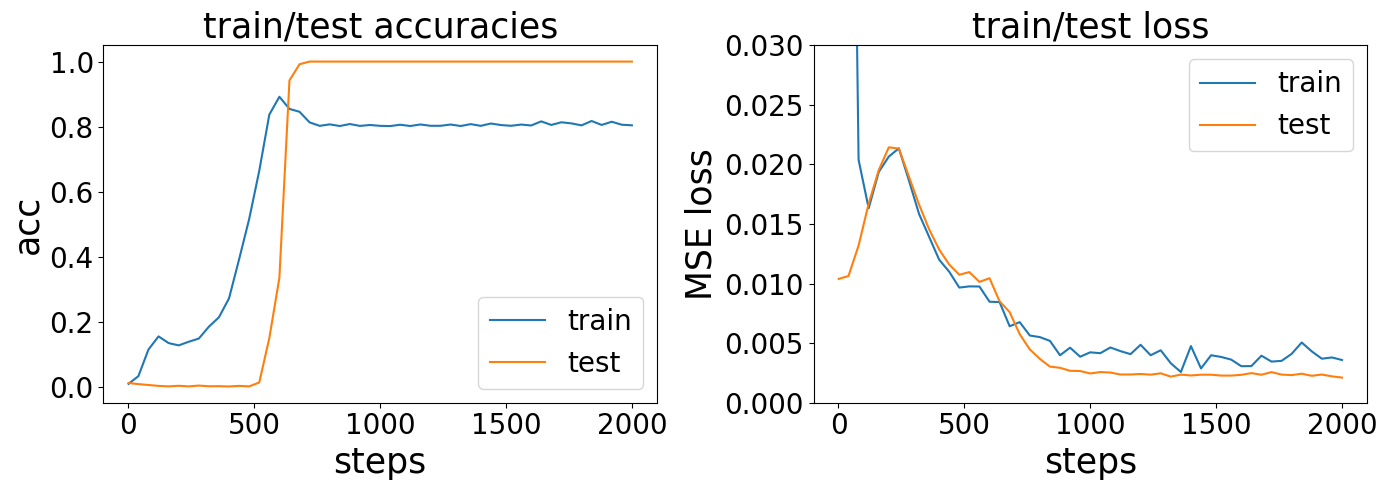

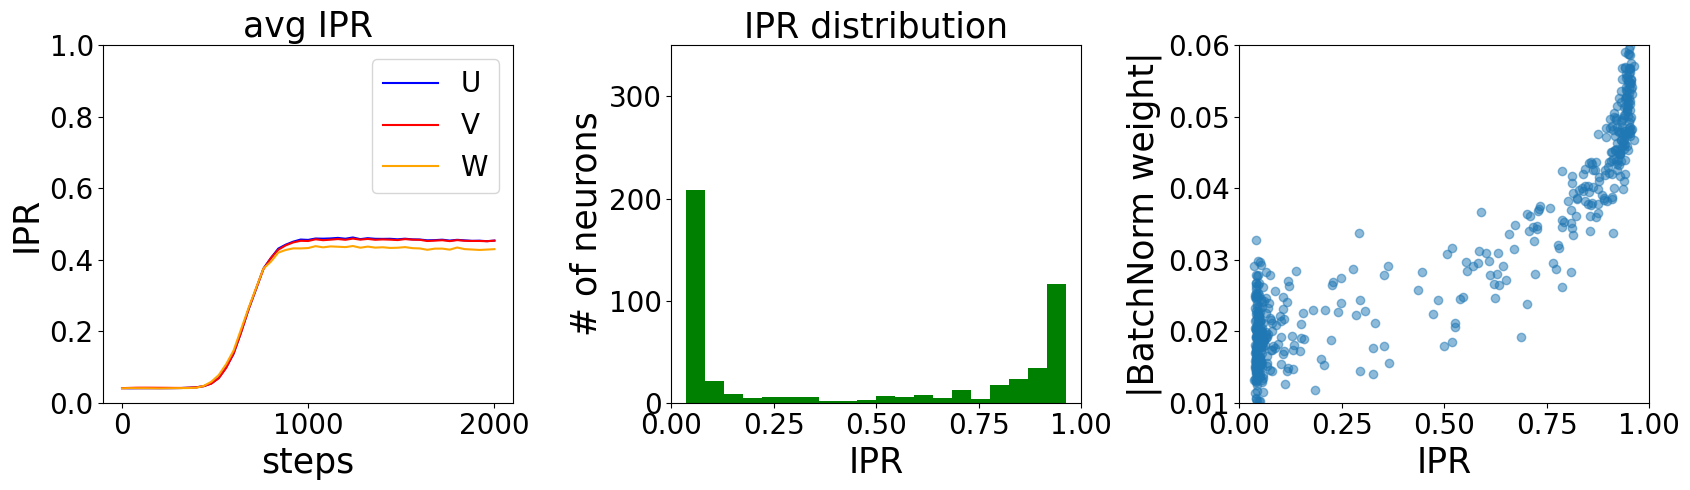

In [19]:
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.title_fontsize'] = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['axes.labelsize'] = 25
plt.rcParams['axes.titlesize'] = 25

## Plot stuff

fig = plt.figure(figsize=(14,5))

## Accuracies
plt.subplot(1,2,1)
plt.title('train/test accuracies')
plt.xlabel('steps')
plt.ylabel('acc')
plt.plot(data_steps, train_accs, label='train')
plt.plot(data_steps, test_accs, label='test')
# plt.axhline(y=1.0, color='black', linestyle='dashed')
plt.legend()

## Losses
plt.subplot(1,2,2)
plt.title('train/test loss')
plt.xlabel('steps')
plt.ylabel('MSE loss')
plt.ylim(0,0.03)
plt.plot(data_steps, train_losses, label='train')
plt.plot(data_steps, test_losses, label='test')
plt.legend()

fig.tight_layout()


fig = plt.figure(figsize=(17,5))

plt.subplot(1,3,1)
plt.title('avg IPR')
plt.xlabel('steps')
plt.ylabel('IPR')
plt.ylim(0,1)
plt.plot(data_steps, iprs['U'].mean(axis=1), color='blue', label='U')
plt.plot(data_steps, iprs['V'].mean(axis=1), color='red', label='V')
plt.plot(data_steps, iprs['W'].mean(axis=1), color='orange', label='W')
plt.legend()

plt.subplot(1,3,2)
plt.title('IPR distribution')
plt.xlabel('IPR')
plt.ylabel('# of neurons')
plt.xlim(0,1)
plt.ylim(0,350)
plt.hist(1/3 * (iprs['U'][-1] + iprs['V'][-1] + iprs['W'][-1]), bins=20, color='green')

plt.subplot(1,3,3)
plt.xlabel('IPR')
plt.ylabel('|BatchNorm weight|')
plt.xlim(0,1)
plt.ylim(0.01,0.06)
plt.scatter(
    1/3 * (iprs['U'][-1] + iprs['V'][-1] + iprs['W'][-1]),
    np.absolute(norm_weights[-1]),
    alpha=0.5
)

fig.tight_layout()

plt.show()

# Minibatch (Partial Inversion)

In [20]:
## Hyperparameters

p  = 97
data_frac = 0.65
noise_level = 0.2

N = 500
dp = 0.0

steps = 2000
data_every = steps // 50
t = 10000000000
wd = 0.0
bs = 64
if bs >= 256: lr = 1e-2
else: lr = 1e-2 * np.sqrt(bs/256)

r = 2


## Dataset

dataset_dict = noisy_dataset(p, pair_seed, data_frac, noise_level, device, dtype, operation='addition', fixed_seed=True)

X_train = dataset_dict['X_train']; Y_train = dataset_dict['Y_train']; X_test = dataset_dict['X_test']; Y_test = dataset_dict['Y_test']
X_og = dataset_dict['X_og']; Y_og = dataset_dict['Y_og']; Y_noisy = dataset_dict['Y_noisy']; orderlist = dataset_dict['orderlist']

total_size = Y_og.shape[0]
train_size = int(p**2 * data_frac)
n_noise = int(train_size * noise_level)

In [21]:
## Training

## Model
model = fcn(2*p, N, p)


## Data Arrays
data_steps = np.arange(data_every, steps+1, data_every)
if 1 not in data_steps: 
    data_steps = np.insert(data_steps, 0, 1)
if steps not in data_steps: 
    data_steps = np.append(data_steps, steps)
    
    
train_losses = np.empty(data_steps.shape[0], float)
test_losses = np.empty(data_steps.shape[0], float)
train_accs = np.empty(data_steps.shape[0], float)
test_accs = np.empty(data_steps.shape[0], float)

weight_norms = {
    'U' : np.empty(data_steps.shape[0], float),
    'V' : np.empty(data_steps.shape[0], float),
    'W' : np.empty(data_steps.shape[0], float),
}

iprs = {
    'U' : np.empty((data_steps.shape[0], N), float),
    'V' : np.empty((data_steps.shape[0], N), float),
    'W' : np.empty((data_steps.shape[0], N), float),
}


## Training loop
optimizer = optim.AdamW(model.parameters(), lr=lr,  weight_decay=wd, betas=(0.9, 0.98), eps=1e-08)


i_d = 0
steps_per_epoch = len(X_train) // bs
step = 1
while step <= steps + 1:
    if (step - 1) % steps_per_epoch == 0:
        perms = torch.randperm(len(X_train), device=device)
        perms = perms[:steps_per_epoch * bs]
        perms = perms.view((steps_per_epoch, bs))

    # train_data = train_one_epoch_grokking_batch(
    #     model, optimizer, bs, X_train, Y_train, X_test, Y_test,
    #     dtype, device, losstype='MSE', if_data=if_data, verbose=False
    # )
    for perm in perms:
        if step in data_steps:
            if_data = True
        else:
            if_data = False
            
        train_data = train_grokking_batchstep(
            model, optimizer, perm, X_train, Y_train, X_test, Y_test,
            dtype, device, losstype='MSE', if_data=if_data, verbose=False
        )
        
        ## collect data
        if if_data:
            train_losses[i_d] = train_data['loss'][-1]
            test_losses[i_d] = train_data['val_loss'][-1]
            train_accs[i_d] = train_data['tr_acc'][-1]
            test_accs[i_d] = train_data['val_acc'][-1]
            
            U = copy.deepcopy(model.fc1.weight.data[:, :p]).detach().cpu().numpy()
            V = copy.deepcopy(model.fc1.weight.data[:, p:]).detach().cpu().numpy()
            W = copy.deepcopy(model.fc2.weight.data).detach().cpu().numpy()        

            weight_norms['U'][i_d] = np.sqrt( (np.abs(U)**2).sum() )
            weight_norms['V'][i_d] = np.sqrt( (np.abs(V)**2).sum() )
            weight_norms['W'][i_d] = np.sqrt( (np.abs(W)**2).sum() )

            for k in range(N):
                iprs['U'][i_d, k] = calculate_ipr( np.absolute(np.fft.rfft(U[k])), r )
                iprs['V'][i_d, k]  = calculate_ipr( np.absolute( np.fft.rfft(V[k])), r )
                iprs['W'][i_d, k] = calculate_ipr( np.absolute( np.fft.rfft(W[:,k])), r )

            print(f'steps:{step} \t train_loss:{train_losses[i_d]} \t test_loss:{test_losses[i_d]} \t train_acc:{train_accs[i_d]} \t test_acc:{test_accs[i_d]}')
            i_d += 1
        
        step += 1


## Print training data at the end of training
print('')       
print('final train loss : {:}'.format(train_losses[-1]))
print('final test loss : {:}'.format(test_losses[-1]))
print('final train acc : {:}'.format(train_accs[-1]))
print('final test acc : {:}'.format(test_accs[-1]))

steps:1 	 train_loss:0.010431823320686817 	 test_loss:0.010337977670133114 	 train_acc:0.016353229762878167 	 test_acc:0.013054037644201578
steps:40 	 train_loss:0.010408212430775166 	 test_loss:0.010433330200612545 	 train_acc:0.29533932951757974 	 test_acc:0.0021250758955676987
steps:80 	 train_loss:0.010421855375170708 	 test_loss:0.010438989847898483 	 train_acc:0.450204415372036 	 test_acc:0.0009107468123861566
steps:120 	 train_loss:0.009853392839431763 	 test_loss:0.010560082271695137 	 train_acc:0.42518397383483236 	 test_acc:0.0009107468123861566
steps:160 	 train_loss:0.010093756951391697 	 test_loss:0.010696427896618843 	 train_acc:0.6417007358953394 	 test_acc:0.004250151791135397
steps:200 	 train_loss:0.008987254463136196 	 test_loss:0.01055839378386736 	 train_acc:0.8539656582174979 	 test_acc:0.012446873102610808
steps:240 	 train_loss:0.00909381452947855 	 test_loss:0.010504926554858685 	 train_acc:0.8770237121831562 	 test_acc:0.0840922890103218
steps:280 	 train_loss

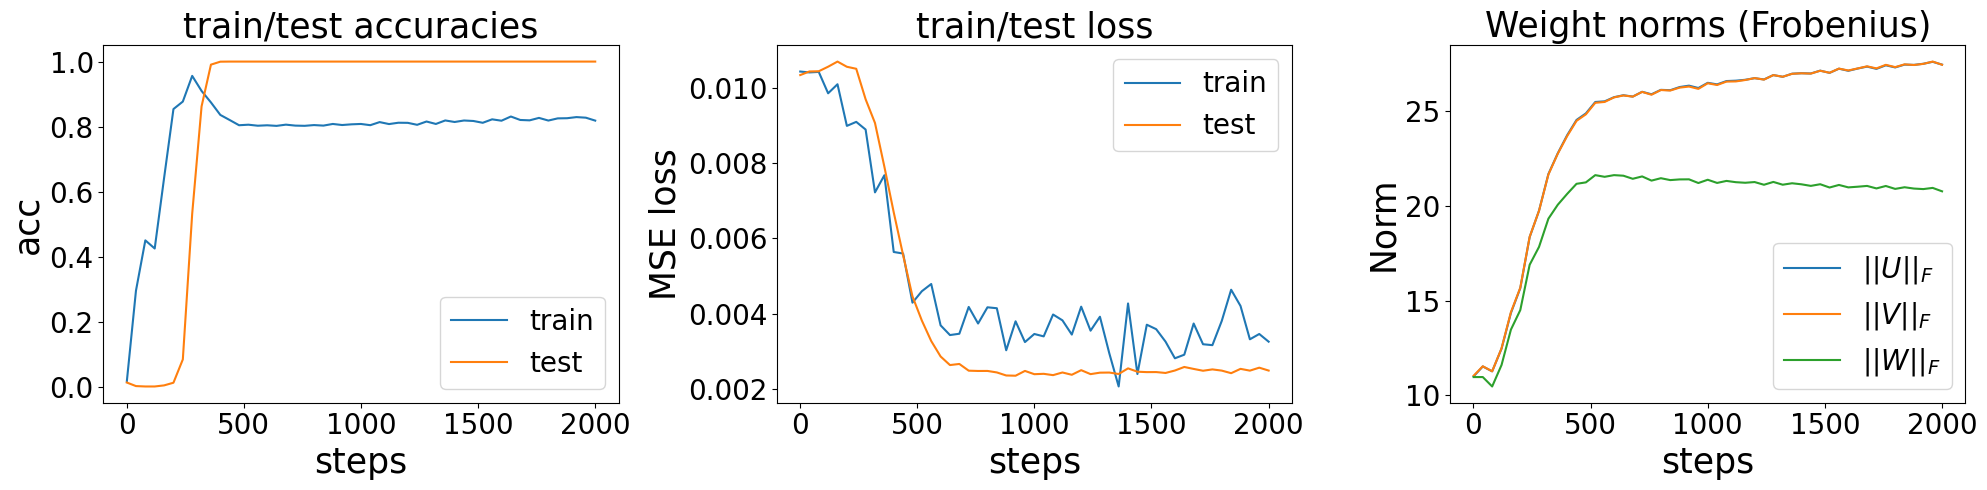

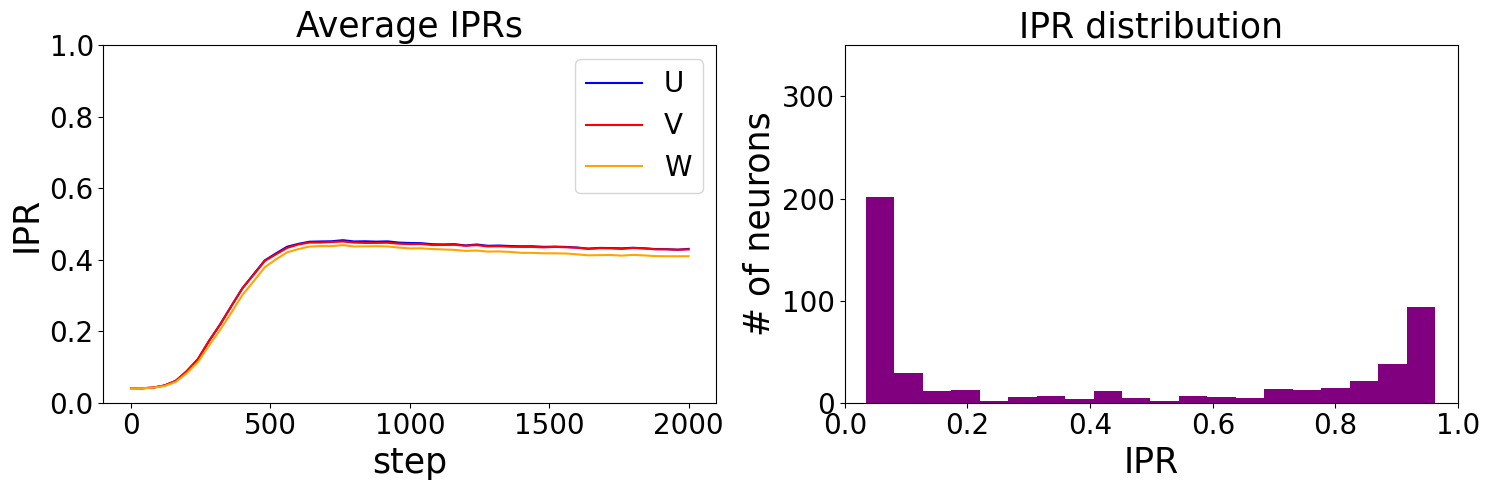

In [22]:
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.title_fontsize'] = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['axes.labelsize'] = 25
plt.rcParams['axes.titlesize'] = 25

## Plot stuff

fig = plt.figure(figsize=(20,5))

## Accuracies
plt.subplot(1,3,1)
plt.title('train/test accuracies')
plt.xlabel('steps')
plt.ylabel('acc')
plt.plot(data_steps, train_accs, label='train')
plt.plot(data_steps, test_accs, label='test')
# plt.axhline(y=1.0, color='black', linestyle='dashed')
plt.legend()

## Losses
plt.subplot(1,3,2)
plt.title('train/test loss')
plt.xlabel('steps')
plt.ylabel('MSE loss')
plt.plot(data_steps, train_losses, label='train')
plt.plot(data_steps, test_losses, label='test')
plt.legend()

## Weight Norms
plt.subplot(1,3,3)
plt.title('Weight norms (Frobenius)')
plt.xlabel('steps')
plt.ylabel('Norm')
plt.plot(data_steps, weight_norms['U'], label='$||U||_F$')
plt.plot(data_steps, weight_norms['V'], label='$||V||_F$')
plt.plot(data_steps, weight_norms['W'], label='$||W||_F$')
plt.legend()

fig.tight_layout()



fig = plt.figure(figsize=(15,5))
        
plt.subplot(1,2,1)
plt.title('Average IPRs')
plt.xlabel('step')
plt.ylabel('IPR')
plt.ylim(0,1)
plt.plot(data_steps, iprs['U'].mean(axis=1), color='blue', label='U')
plt.plot(data_steps, iprs['V'].mean(axis=1), color='red', label='V')
plt.plot(data_steps, iprs['W'].mean(axis=1), color='orange', label='W')
# plt.axhline(y=1.0, color='black', linestyle='dashed', label='pure freq')
plt.legend()

plt.subplot(1,2,2)
plt.title('IPR distribution')
plt.xlabel('IPR')
plt.ylabel('# of neurons')
plt.xlim(0,1)
plt.ylim(0,350)
plt.hist(1/3 * (iprs['U'][-1] + iprs['V'][-1] + iprs['W'][-1]), bins=20, color='purple')

fig.tight_layout()

plt.show()

# Pruning (from Coexistence phase)

In [23]:
## Hyperparameters

p  = 97
data_frac = 0.5
noise_level = 0.35

N = 500
dp = 0.0

epochs = 1000
data_every = epochs // 50
t = 10000000000
lr = 1e-2
wd = 0.0

r = 2


## Dataset

dataset_dict = noisy_dataset(p, pair_seed, data_frac, noise_level, device, dtype, operation='addition', fixed_seed=True)

X_train = dataset_dict['X_train']; Y_train = dataset_dict['Y_train']; X_test = dataset_dict['X_test']; Y_test = dataset_dict['Y_test']
X_og = dataset_dict['X_og']; Y_og = dataset_dict['Y_og']; Y_noisy = dataset_dict['Y_noisy']; orderlist = dataset_dict['orderlist']

total_size = Y_og.shape[0]
train_size = int(p**2 * data_frac)
n_noise = int(train_size * noise_level)

In [24]:
## Training

## Model
model = fcn(2*p, N, p, dp=dp)


## Data Arrays
data_epochs = np.arange(data_every, epochs+1, data_every)
if 1 not in data_epochs: 
    data_epochs = np.insert(data_epochs, 0, 1)
if epochs not in data_epochs: 
    data_epochs = np.append(data_epochs, epochs)
    
    
train_losses = np.empty(data_epochs.shape[0], float)
test_losses = np.empty(data_epochs.shape[0], float)
train_accs = np.empty(data_epochs.shape[0], float)
test_accs = np.empty(data_epochs.shape[0], float)


weight_norms = {
    'U' : np.empty(data_epochs.shape[0], float),
    'V' : np.empty(data_epochs.shape[0], float),
    'W' : np.empty(data_epochs.shape[0], float)
}


iprs = {
    'U' : np.empty((data_epochs.shape[0], N), float),
    'V' : np.empty((data_epochs.shape[0], N), float),
    'W' : np.empty((data_epochs.shape[0], N), float),
    'U_grad' : np.empty((data_epochs.shape[0], N), float),
    'V_grad' : np.empty((data_epochs.shape[0], N), float),
    'W_grad' : np.empty((data_epochs.shape[0], N), float)
}


## Training loop
optimizer = optim.AdamW(model.parameters(), lr=lr,  weight_decay=wd, betas=(0.9, 0.98), eps=1e-08)


i_d = 0
for epoch in range(1,epochs+1):
    if epoch in data_epochs:
        if_data = True
    else:
        if_data = False
        
    train_data = train_one_epoch_grokking(
        model, optimizer, t, X_train, Y_train, X_test, Y_test,
        dtype, device, losstype='MSE', if_data=if_data, verbose=False
    )
    
    ## collect data
    if if_data:
        train_losses[i_d] = train_data['loss'][-1]
        test_losses[i_d] = train_data['val_loss'][-1]
        train_accs[i_d] = train_data['tr_acc'][-1]
        test_accs[i_d] = train_data['val_acc'][-1]
        
        U = copy.deepcopy(model.fc1.weight.data[:, :p]).detach().cpu().numpy()
        V = copy.deepcopy(model.fc1.weight.data[:, p:]).detach().cpu().numpy()
        W = copy.deepcopy(model.fc2.weight.data).detach().cpu().numpy()

        weight_norms['U'][i_d] = np.sqrt( (np.abs(U)**2).sum() )
        weight_norms['V'][i_d] = np.sqrt( (np.abs(V)**2).sum() )
        weight_norms['W'][i_d] = np.sqrt( (np.abs(W)**2).sum() )

        for k in range(N):
            iprs['U'][i_d, k] = calculate_ipr( np.absolute(np.fft.rfft(U[k])), r )
            iprs['V'][i_d, k]  = calculate_ipr( np.absolute( np.fft.rfft(V[k])), r )
            iprs['W'][i_d, k] = calculate_ipr( np.absolute( np.fft.rfft(W[:,k])), r )

        print(f'epoch epochs:{epoch} \t train_loss:{train_losses[i_d]} \t test_loss:{test_losses[i_d]} \t train_acc:{train_accs[i_d]} \t test_acc:{test_accs[i_d]}')
        
        i_d += 1


## Print training data at the end of training
print('')       
print('final train loss : {:}'.format(train_losses[-1]))
print('final test loss : {:}'.format(test_losses[-1]))
print('final train acc : {:}'.format(train_accs[-1]))
print('final test acc : {:}'.format(test_accs[-1]))

epoch epochs:1 	 train_loss:0.010413740761578083 	 test_loss:0.010478144511580467 	 train_acc:0.051658163265306124 	 test_acc:0.0076514346439957494
epoch epochs:20 	 train_loss:0.007833055220544338 	 test_loss:0.01278685312718153 	 train_acc:0.9955357142857143 	 test_acc:0.003188097768331562
epoch epochs:40 	 train_loss:0.00635603116825223 	 test_loss:0.014826697297394276 	 train_acc:1.0 	 test_acc:0.007226354941551541
epoch epochs:60 	 train_loss:0.005661047995090485 	 test_loss:0.015977291390299797 	 train_acc:1.0 	 test_acc:0.010839532412327312
epoch epochs:80 	 train_loss:0.0052738795056939125 	 test_loss:0.016482416540384293 	 train_acc:1.0 	 test_acc:0.017215727948990435
epoch epochs:100 	 train_loss:0.005007733590900898 	 test_loss:0.016624679788947105 	 train_acc:1.0 	 test_acc:0.02975557917109458
epoch epochs:120 	 train_loss:0.0048029604367911816 	 test_loss:0.016628077253699303 	 train_acc:1.0 	 test_acc:0.04760892667375133
epoch epochs:140 	 train_loss:0.004638071171939373 

In [25]:
## Pruning

X_crr = X_train[:n_noise]; Y_crr = Y_train[:n_noise]
X_noncrr = X_train[n_noise:]; Y_noncrr = Y_train[n_noise:]

ipr_k = (iprs['U'][-1] + iprs['V'][-1] + iprs['W'][-1])/3
sorted_args = np.argsort(ipr_k)

train_loss_pruned = np.empty(N, float)
test_loss_pruned = np.empty(N, float)
train_acc_pruned = np.empty(N, float)
test_acc_pruned = np.empty(N, float)
train_acc_crr = np.empty(N, float)
train_acc_noncrr = np.empty(N, float)
acc_og = np.empty(N, float)

random_args = np.arange(N)
np.random.shuffle(random_args)

for n_prune in range(N):
    net = copy.deepcopy(model)
    net.fc1.weight.data[sorted_args[:int(n_prune)], :p] = 0
    net.fc1.weight.data[sorted_args[:int(n_prune)], p:] = 0
    net.fc2.weight.data[:, sorted_args[:int(n_prune)]] = 0

    train_loss_pruned[n_prune] = calculate_loss(net, X_train.to(dtype=dtype), Y_train.to(device=device), p=p, losstype='MSE')
    test_loss_pruned[n_prune] = calculate_loss(net, X_test.to(dtype=dtype), Y_test.to(device=device), p=p, losstype='MSE')
    train_acc_pruned[n_prune] = check_accuracy_grokking(X_train, Y_train, net, dtype, device, None)[-1]
    test_acc_pruned[n_prune] = check_accuracy_grokking(X_test, Y_test, net, dtype, device, None)[-1]
    train_acc_crr[n_prune] = check_accuracy_grokking(X_crr, Y_crr, net, dtype, device, None)[-1]
    train_acc_noncrr[n_prune] = check_accuracy_grokking(X_noncrr, Y_noncrr, net, dtype, device, None)[-1]
    acc_og[n_prune] = check_accuracy_grokking(X_og, Y_og, net, dtype, device, None)[-1]
    
    
## Reverse

sorted_args_rev = np.argsort(ipr_k)[::-1].copy()

train_loss_pruned_rev = np.empty(N, float)
test_loss_pruned_rev = np.empty(N, float)
train_acc_pruned_rev = np.empty(N, float)
test_acc_pruned_rev = np.empty(N, float)
train_acc_crr_rev = np.empty(N, float)
train_acc_noncrr_rev = np.empty(N, float)
acc_og_rev = np.empty(N, float)

random_args_rev = np.arange(N)
np.random.shuffle(random_args)

for n_prune in range(N):
    net = copy.deepcopy(model)
    net.fc1.weight.data[sorted_args_rev[:int(n_prune)], :p] = 0
    net.fc1.weight.data[sorted_args_rev[:int(n_prune)], p:] = 0
    net.fc2.weight.data[:, sorted_args_rev[:int(n_prune)]] = 0

    train_loss_pruned_rev[n_prune] = calculate_loss(net, X_train.to(dtype=dtype), Y_train.to(device=device), p=p, losstype='MSE')
    test_loss_pruned_rev[n_prune] = calculate_loss(net, X_test.to(dtype=dtype), Y_test.to(device=device), p=p, losstype='MSE')
    train_acc_pruned_rev[n_prune] = check_accuracy_grokking(X_train, Y_train, net, dtype, device, None)[-1]
    test_acc_pruned_rev[n_prune] = check_accuracy_grokking(X_test, Y_test, net, dtype, device, None)[-1]
    train_acc_crr_rev[n_prune] = check_accuracy_grokking(X_crr, Y_crr, net, dtype, device, None)[-1]
    train_acc_noncrr_rev[n_prune] = check_accuracy_grokking(X_noncrr, Y_noncrr, net, dtype, device, None)[-1]
    acc_og_rev[n_prune] = check_accuracy_grokking(X_og, Y_og, net, dtype, device, None)[-1]

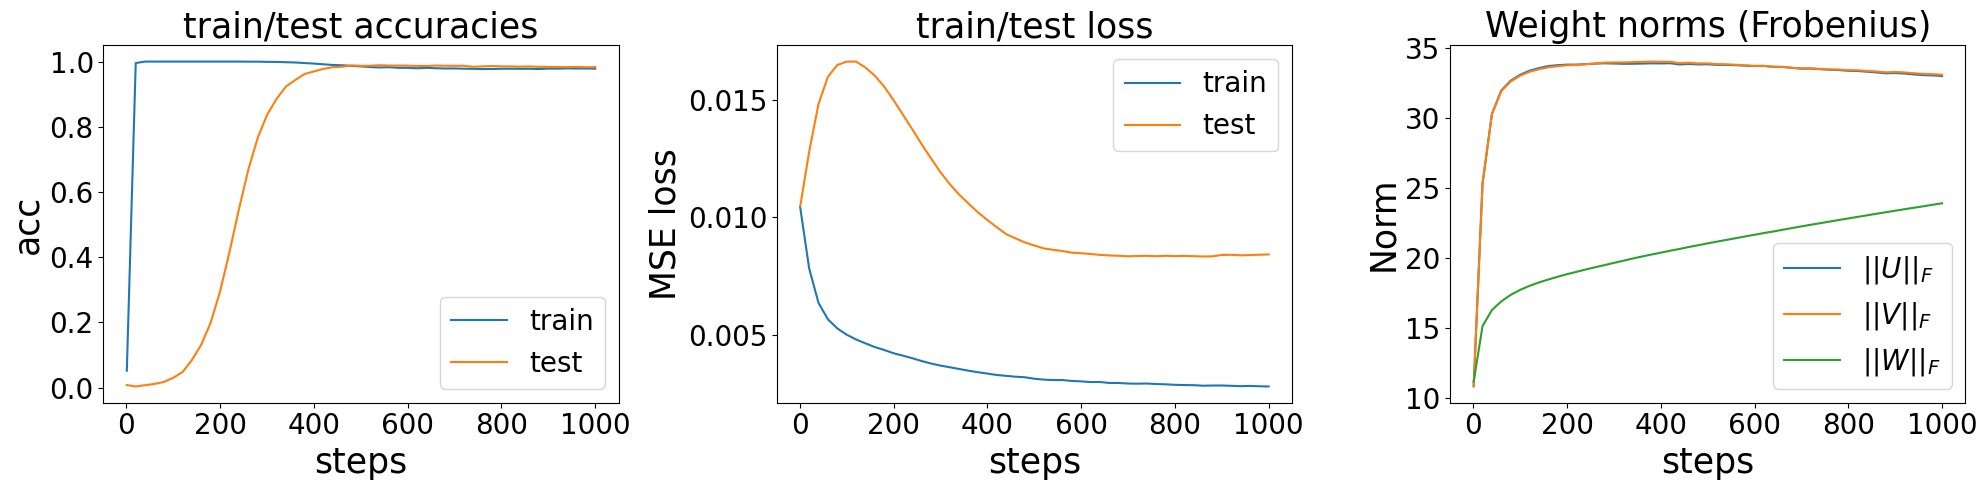

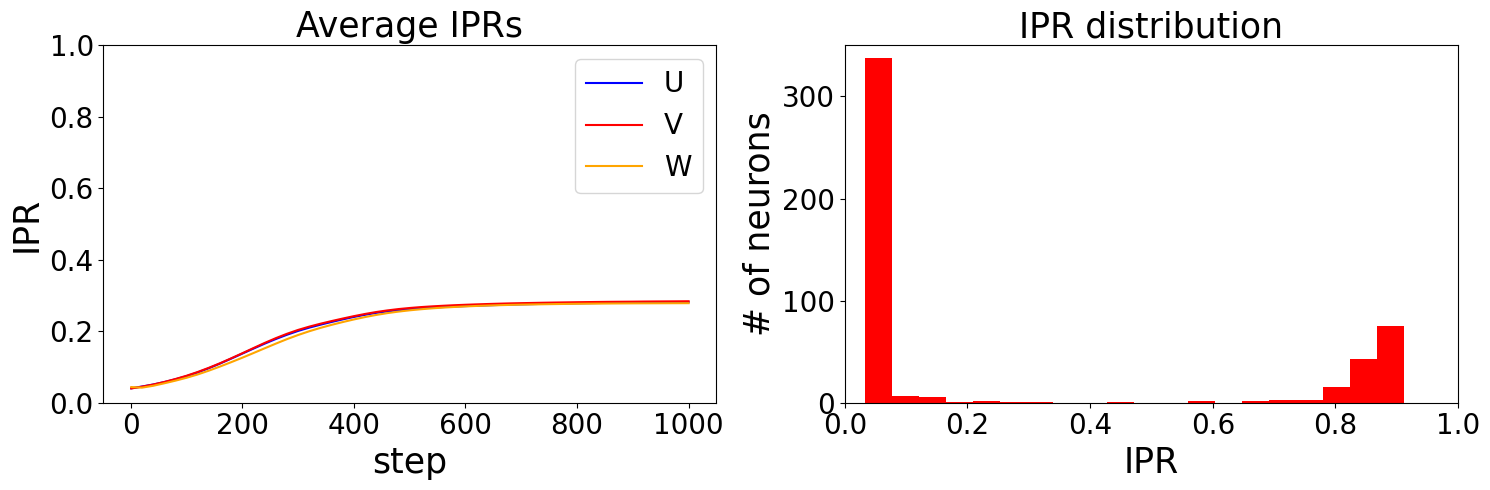

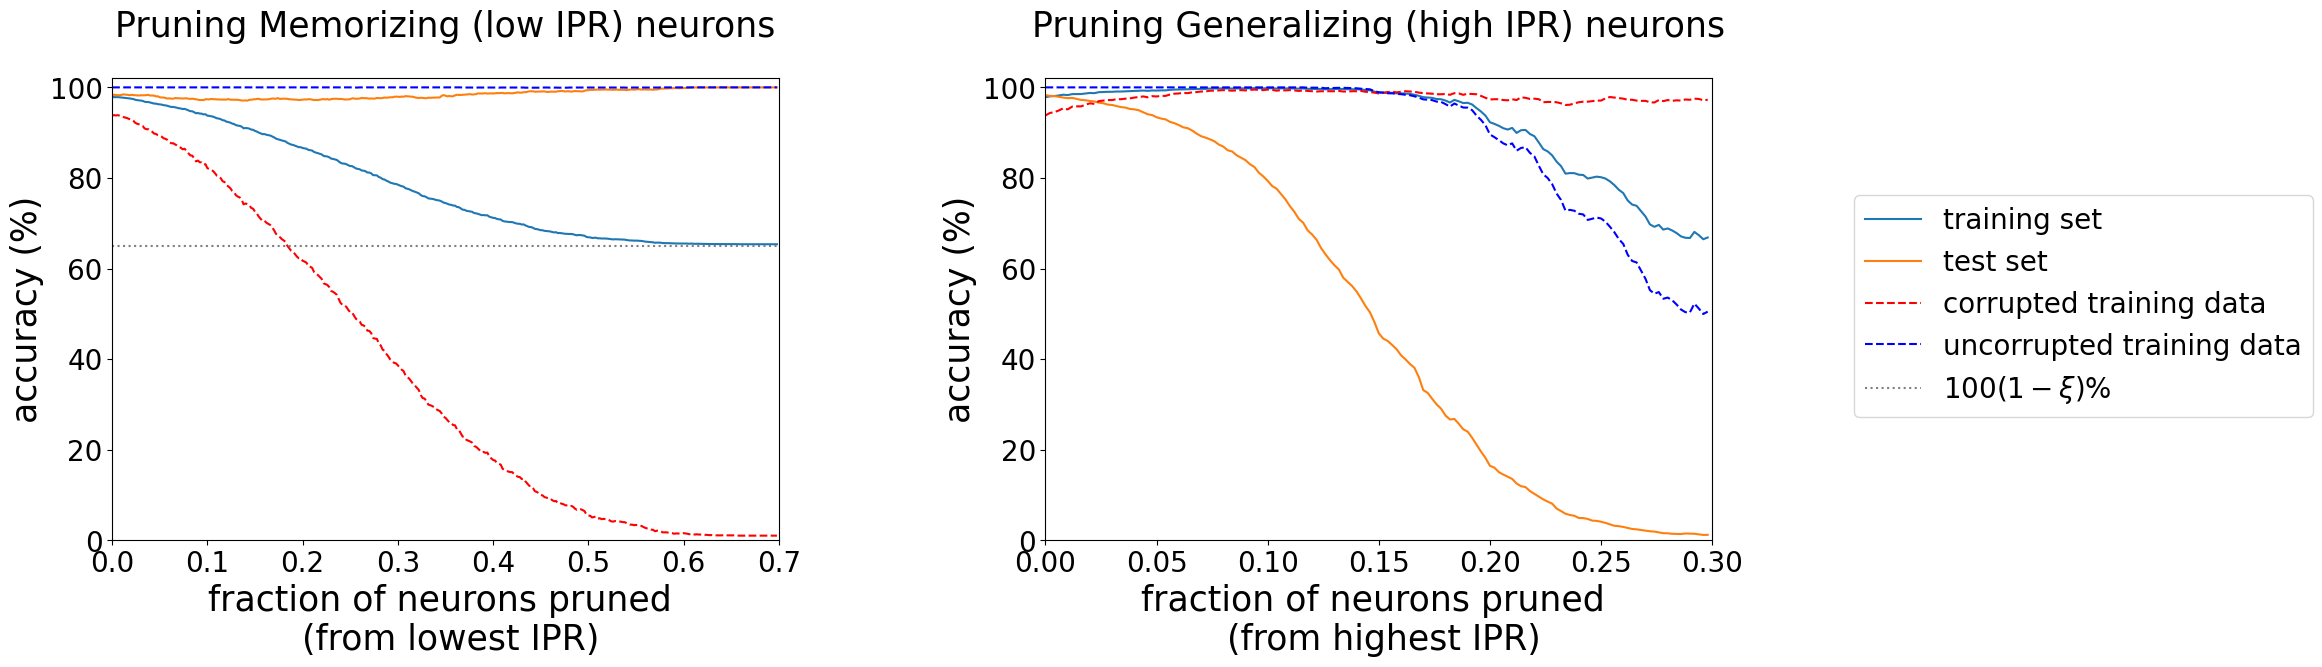

In [26]:
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.title_fontsize'] = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['axes.labelsize'] = 25
plt.rcParams['axes.titlesize'] = 25

## Plot stuff

fig = plt.figure(figsize=(20,5))

## Accuracies
plt.subplot(1,3,1)
plt.title('train/test accuracies')
plt.xlabel('steps')
plt.ylabel('acc')
plt.plot(data_epochs, train_accs, label='train')
plt.plot(data_epochs, test_accs, label='test')
# plt.axhline(y=1.0, color='black', linestyle='dashed')
plt.legend()

## Losses
plt.subplot(1,3,2)
plt.title('train/test loss')
plt.xlabel('steps')
plt.ylabel('MSE loss')
plt.plot(data_epochs, train_losses, label='train')
plt.plot(data_epochs, test_losses, label='test')
plt.legend()

## Weight Norms
plt.subplot(1,3,3)
plt.title('Weight norms (Frobenius)')
plt.xlabel('steps')
plt.ylabel('Norm')
plt.plot(data_epochs, weight_norms['U'], label='$||U||_F$')
plt.plot(data_epochs, weight_norms['V'], label='$||V||_F$')
plt.plot(data_epochs, weight_norms['W'], label='$||W||_F$')
plt.legend()

fig.tight_layout()



fig = plt.figure(figsize=(15,5))
        
plt.subplot(1,2,1)
plt.title('Average IPRs')
plt.xlabel('step')
plt.ylabel('IPR')
plt.ylim(0,1)
plt.plot(data_epochs, iprs['U'].mean(axis=1), color='blue', label='U')
plt.plot(data_epochs, iprs['V'].mean(axis=1), color='red', label='V')
plt.plot(data_epochs, iprs['W'].mean(axis=1), color='orange', label='W')
# plt.axhline(y=1.0, color='black', linestyle='dashed', label='pure freq')
plt.legend()

plt.subplot(1,2,2)
plt.title('IPR distribution')
plt.xlabel('IPR')
plt.ylabel('# of neurons')
plt.xlim(0,1)
plt.ylim(0,350)
plt.hist(1/3 * (iprs['U'][-1] + iprs['V'][-1] + iprs['W'][-1]), bins=20, color='red')

fig.tight_layout()


fig = plt.figure(figsize=(16,6))

gs1 = fig.add_gridspec(nrows = 1, ncols=2, left=0, right=1.0, wspace=0.4)

n_prune_forward = 350
ax0 = fig.add_subplot(gs1[:,0])
ax0.set_title('Pruning Memorizing (low IPR) neurons', pad=30)
ax0.set_xlabel('fraction of neurons pruned \n (from lowest IPR)')
ax0.set_ylabel('accuracy (%)')
ax0.set_xlim(0,n_prune_forward/N)
ax0.set_ylim(0,102)
ax0.tick_params('both',)

ax0.plot(np.arange(n_prune_forward)/N, 100*train_acc_pruned[:n_prune_forward], label='training set')
ax0.plot(np.arange(n_prune_forward)/N, 100*test_acc_pruned[:n_prune_forward], label='test set')
ax0.plot(np.arange(n_prune_forward)/N, 100*train_acc_crr[:n_prune_forward], label='corrupted training data', color='red', linestyle='dashed')
ax0.plot(np.arange(n_prune_forward)/N, 100*train_acc_noncrr[:n_prune_forward], label='uncorrupted training data', color='blue', linestyle='dashed')
ax0.axhline(y=100*(1-noise_level), color='grey', linestyle='dotted', label='$100(1-\\xi)\%$')

n_prune_rev = 150
ax1 = fig.add_subplot(gs1[:,1])
ax1.set_title('Pruning Generalizing (high IPR) neurons', pad=30)
ax1.set_xlabel('fraction of neurons pruned \n (from highest IPR)')
plt.ylabel('accuracy (%)')
ax1.set_xlim(0,n_prune_rev/N)
ax1.set_ylim(0,102)
ax1.tick_params('both')

ax1.plot(np.arange(n_prune_rev)/N, 100*train_acc_pruned_rev[:n_prune_rev], label='training set')
ax1.plot(np.arange(n_prune_rev)/N, 100*test_acc_pruned_rev[:n_prune_rev], label='test set')
ax1.plot(np.arange(n_prune_rev)/N, 100*train_acc_crr_rev[:n_prune_rev], label='corrupted training data', color='red', linestyle='dashed')
ax1.plot(np.arange(n_prune_rev)/N, 100*train_acc_noncrr_rev[:n_prune_rev], label='uncorrupted training data', color='blue', linestyle='dashed')

lines, labels = ax0.get_legend_handles_labels()
fig.legend(lines, labels, loc='center left', bbox_to_anchor=(1.08,0.5))

plt.show()